<a href="https://colab.research.google.com/github/eeuunnjjiii/kaggle_survey2021/blob/main/3rd_kaggle_survey2021_EJJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What Makes Difference Between A Job Title - DA / DS / DE

# 0. Introduction 
### Coding and Data Analysis

These are the most trending words around the world and it has taken over the country. 
 
Many education-tech companies in Korea has started launching data-related courses and programs. Our team is also one of them who have a different background and are actively seeking a data-related job. However, it is pretty hard to decide which job title or role would fit due to unsettled definitions or roles among Data Scientist (DS), Data Anaylst(DA), and Data Engineer(DE) across industries.

As a job seeker, the team would like to at least grasp the approximate role or necessary skills to be one of them (DS, DA, DE, etc.).

This notebook will focus on questions that job seekers or beginners like us would be curious about data-related industry and we hope to gain much clearer comprehensive veiw of state of data-related jobs to be prepared.


Let's dive into the survey!

# Libraries

In [1]:
!pip install squarify
!pip install pywaffle
!pip install --upgrade plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set(font_scale = 2.5) # Setting up font size as default
from collections import OrderedDict # Set up color dictionary in order

import squarify           # Treemap
plt.style.use('fivethirtyeight')
from pywaffle import Waffle

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# plotly
import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

# 1. Import Dataset

In [3]:
response = pd.read_csv('kaggle_survey_2021_responses.csv', encoding = 'utf-8')
response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool

In [4]:
# Save Questions as a list and fill missing values into ''
question_list = response.iloc[0,].values
response = response.iloc[1:,:].reset_index(drop = True)
response.fillna('', inplace = True)
response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_Part_12,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,...,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_Part_12,Q34_B_Part_13,Q34_B_Part_14,Q34_B_Part_15,Q34_B_Part_16,Q34_B_OTHER,Q36_B_Part_1,Q36_B_Part_2,Q36_B_Part_3,Q36_B_Part_4,Q36_B_Part_5,Q36_B_Part_6,Q36_B_Part_7,Q36_B_OTHER,Q37_B_Part_1,Q37_B_Part_2,Q37_B_Part_3,Q37_B_Part_4,Q37_B_Part_5,Q37_B_Part_6,Q37_B_Part_7,Q37_B_OTHER,Q38_B_Part_1,Q38_B_Part_2,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,,,,,,,,,,,,Python,,,,,,,,,Vim / Emacs,,,,,,Colab Notebooks,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,,,SQL,C,C++,Java,,,,,,,,Python,,,,,,,Notepad++,,,,Jupyter Notebook,,,Kaggle Notebooks,Colab Notebooks,,,,,...,,,Qlik,,,,,,,,,,,,"Automated model selection (e.g. auto-sklearn, ...",,,,,,Google Cloud AutoML,,,,,,,,,,,,,,,,,,None,
2,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,,,,C++,Java,,,,,,,,Python,,,,,PyCharm,,,,,,Jupyter Notebook,,Other,Kaggle Notebooks,,,,,,...,,,,,,,,,,,,,,,"Automated model selection (e.g. auto-sklearn, ...",,,,,,,,,DataRobot AutoML,,,,,,,,,TensorBoard,,,,,,,
3,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,,,,,,,,,,,,,Python,,,,,,Spyder,,,,,Jupyter Notebook,,,,Colab Notebooks,,,,,...,,,,,,,,,,,None,,,,,,,,None,,,,,,,,,,,,,,,,,,,,None,
4,781,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,,,C,,,,,,,MATLAB,,,Python,,,,,,Spyder,,,,MATLAB,Jupyter Notebook,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


# 2. Feature Engineering and Data Wrangling

## 2.1 Combining all relevant features
   
At the first glance, the team recognizes that some features come from a single multiple-choice question. Thus, we decide to combine all relavent features into one feature.


In [5]:
def total_answer(df, column):
    """
    A function to combine all relevant features coming from a multiple-choice question
    column : column name
    """ 
    # Extract all relevant columns corresponding to 'column'
    col = df.columns[df.columns.str.contains(column)]
    tmp = df[col]
    # Fill missing values with empty space ''
    tmp = tmp.fillna('')
    
    # Add comma(,) between answers
    total = tmp.apply(','.join, axis=1)

    # Remove unnecessary comma(,)
    import re
    ls = []
    for i in total:
        ls.append(re.sub(',{2,}', ',', i).strip(',')) ## Replace double commas into one

    # Delete the rest of columns that are already used
    df.drop(col, axis=1, inplace=True)

    # Store the combined answers into a column
    df[column] = ls


In [6]:
# Apply total_answer() to only multiple-type questions

q_list_supplementary = [27,29,30,31,32,34,36,37,38] # supplementary question list

for i in range(7, 43):
    if i in q_list_supplementary:
        num_A = 'Q' + str(i) + '_A'
        num_B = 'Q' + str(i) + '_B'
        total_answer(response ,num_A)
        total_answer(response ,num_B)
    
    else:
        num = 'Q'+str(i)
        total_answer(response ,num)
response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27_A,Q27_B,Q28,Q29_A,Q29_B,Q30_A,Q30_B,Q31_A,Q31_B,Q32_A,Q32_B,Q33,Q34_A,Q34_B,Q35,Q36_A,Q36_B,Q37_A,Q37_B,Q38_A,Q38_B,Q39,Q40,Q41,Q42
0,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,,Google Cloud Compute Engine,,Google Cloud Storage (GCS),,No / None,,PostgreSQL,,,None,,,No / None,,,,No / None,,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ..."
1,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,"SQL,C,C++,Java",Python,"Notepad++ , Jupyter Notebook","Kaggle Notebooks,Colab Notebooks","A cloud computing platform (AWS, Azure, GCP, h...",None,Never,Matplotlib,Under 1 year,Scikit-learn,"Linear or Logistic Regression,Decision Trees o...",,,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,Build and/or run the data infrastructure that ...,"60,000-69,999",$0 ($USD),,"Google Cloud Platform (GCP) , Oracle Cloud",,,Google Cloud Compute Engine,,,,None,,"MySQL ,SQLite ,Oracle Database ,Google Cloud SQL",,,"Google Data Studio,Qlik",,,"Automated model selection (e.g. auto-sklearn, ...",,Google Cloud AutoML,,None,,"Kaggle Learn Courses,Cloud-certification progr...","Advanced statistical software (SPSS, SAS, etc.)","Journal Publications (peer-reviewed journals, ..."
2,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,"Python,C++,Java",Python,"PyCharm , Jupyter Notebook,Other",Kaggle Notebooks,A laptop,Other,Never,Matplotlib,I do not use machine learning methods,,,,,Academics/Education,"1000-9,999 employees",0,I do not know,None of these activities are an important part...,$0-999,$0 ($USD),None,"Amazon Web Services (AWS) , Google Cloud Plat...",,,"Microsoft Azure Virtual Machines , Google Clo...",,,DataRobot,"Azure Machine Learning Studio , Google Cloud ...","MySQL ,MongoDB","MySQL ,PostgreSQL ,MongoDB",MySQL,None,"Microsoft Power BI,Tableau",,No / None,"Automated model selection (e.g. auto-sklearn, ...",,DataRobot AutoML,No / None,TensorBoard,I do not share my work publicly,DataCamp,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),YouTube (Kaggl..."
3,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,Python,"Spyder , Jupyter Notebook",Colab Notebooks,"A cloud computing platform (AWS, Azure, GCP, h...",NVIDIA GPUs,More than 25 times,Matplotlib,5-10 years,"Scikit-learn , TensorFlow , Keras","Dense Neural Networks (MLPs, etc),Convolutiona...","General purpose image/video tools (PIL, cv2, s...",None,Academics/Education,"1000-9,999 employees",0,I do not know,Do research that advances the state of the art...,"30,000-39,999",$0 ($USD),,"Amazon Web Services (AWS) , Microsoft Azure",,,"Microsoft Azure Virtual Machines , Google Clo...",,,,None,,None,,,None,,,None,,,,None,,"Coursera,edX","Local development environments (RStudio, Jupyt...","YouTube (Kaggle YouTube, Cloud AI Adventures, ..."
4,781,45-49,Man,India,Doctoral degree,Other,< 1 years,"Python,C,MATLAB",Python,"Spyder , MATLAB , Jupyter Notebook",Google Cloud Datalab,"A cloud computing platform (AWS, Azure, GCP, h...",None,Never,"Matplotlib , Seaborn , Ggplot / ggplot2",10-20 years,"Scikit-learn , PyTorch , LightGBM","Linear or Logistic Regression,Decision Trees o...",,,Academi

## 2.2 Regrouping Job Title: 
### DA (Data Analysist) vs DE (Data Engineering) vs DS (Data Scientist) vs Other

Among 15 different jop titles in survey, the team regroup them into four typical jobs DA, DE, DS and others to help out those who are interested in data-related job but have no idea which one would fit for themseleves

Here is how we regroup:

|Group | List of Job Title|
|:--|:--|
|DA (Data Analysist) | 'Business Analyst', 'Data Analyst', 'Product Manager', 'Program/Project Manager', 'Statistician'
| DE (Data Engineering) | 'Data Engineer', 'DBA/Database Engineer', 'Machine Learning Engineer', 'Software Engineer', 'Developer Relations/Advocacy'
|DS (Data Scientist) | 'Data Scientist', 'Research Scientist'
|Other |'Student', 'Currently not employed', 'Other'

In [7]:
response['RegroupJobTitle'] = response['Q5'].copy()
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Business Analyst', 'Data Analyst', 'Product Manager', 'Program/Project Manager', 'Statistician'],'DA')
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Data Engineer', 'DBA/Database Engineer', 'Machine Learning Engineer', 'Software Engineer', 'Developer Relations/Advocacy'], 'DE')
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Data Scientist', 'Research Scientist'], 'DS')
response['RegroupJobTitle'] = response['RegroupJobTitle'].replace(['Student', 'Currently not employed', 'Other'], 'OTHER')

In [8]:
response['RegroupJobTitle'].value_counts(normalize = True)

OTHER    0.430563
DS       0.198437
DE       0.188118
DA       0.182882
Name: RegroupJobTitle, dtype: float64

## 2.3 Professionals Vs Non-professionals

By definition of "Non-professionals" in '2021 Kaggle DS & ML Survey Final List of Questions' file,

*Non-professionals* were defined as students, unemployed, and respondents that have
never spent any money in the cloud.

All supplement questions for non-professionals asked **what tools they hope to become familiar with in the next 2 years** instead of asking what tools they use on a regular basis.

In [9]:
cond = ((response['Q27_B'] != '') | (response['Q29_B'] != '') | (response['Q30_B'] != '') | 
        (response['Q31_B'] != '') | (response['Q32_B'] != '') | (response['Q34_B'] != '') | 
        (response['Q36_B'] != '') | (response['Q37_B'] != '') | (response['Q38_B'] != ''))

response['professional'] = 'Professional'
response.loc[cond, 'professional'] = 'Non-professional'

In [10]:
response['professional'].value_counts(normalize = True)

Non-professional    0.51954
Professional        0.48046
Name: professional, dtype: float64

## 2.4 Rename Columns

In [11]:
# Rename columns
question_name_dict = {'Q1':'Age', 'Q2': 'Gender', 'Q3':'Country', 'Q4':'FormalEducation',
                      'Q5':'JobTitle','Q6':'YearsToCode', 'Q7':'Language_regular', 'Q8': 'Language_first',
                      'Q9':'IDE', 'Q10':'Notebook', 'Q11':'Computer', 'Q12':'Hardware', 'Q13':'Duration_TPU',
                      'Q14':'Vis_library', 'Q15':'Years_ML_Method','Q16':'ML_framework', 'Q17':'ML_algorithm',
                      'Q18':'Method_CV', 'Q19':'Method_NLP', 'Q20':'JobIndustry', 'Q21':'CompanySize',
                      'Q22':'Num_Workloads', 'Q23':'ML_Applied', 'Q24':'Activities_role', 'Q25':'Year_Compensation',
                      'Q26':'Spent_amount_ML', 'Q27_A':'Cloud_platform_A', 'Q27_B':'Cloud_platform_B', 
                      'Q28':'Best_Cloud_platform','Q29_A':'Use_Cloud_platform_A','Q29_B':'Use_Cloud_platform_B',
                      'Q30_A':'Use_Data_Storage_A','Q30_B':'Use_Data_Storage_B', 'Q31_A':'Use_ML_product_A',
                      'Q31_B':'Use_ML_product_B','Q32_A':'BigData_product_A','Q32_B':'BigData_product_B',
                      'Q33':'Best_BigData_product','Q34_A':'BI_Tool_A','Q34_B':'BI_Tool_B','Q35':'Best_BI_Tool',
                      'Q36_A':'AutoML_Tool_A','Q36_B':'AutoML_Tool_B','Q37_A':'Which_AutoML_Tool_A',
                      'Q37_B':'Which_AutoML_Tool_B','Q38_A':'ManageML_A','Q38_B':'ManageML_B',
                      'Q39':'PublicToDeploy',
                      'Q40':'PlatformToLear_DS','Q41':'PrimaryTool','Q42':'MediaSourceToLearn'
                     }

response = response.rename(columns = question_name_dict)
response.head()

,Time from Start to Finish (seconds),Age,Gender,Country,FormalEducation,JobTitle,YearsToCode,Language_regular,Language_first,IDE,Notebook,Computer,Hardware,Duration_TPU,Vis_library,Years_ML_Method,ML_framework,ML_algorithm,Method_CV,Method_NLP,JobIndustry,CompanySize,Num_Workloads,ML_Applied,Activities_role,Year_Compensation,Spent_amount_ML,Cloud_platform_A,Cloud_platform_B,Best_Cloud_platform,Use_Cloud_platform_A,Use_Cloud_platform_B,Use_Data_Storage_A,Use_Data_Storage_B,Use_ML_product_A,Use_ML_product_B,BigData_product_A,BigData_product_B,Best_BigData_product,BI_Tool_A,BI_Tool_B,Best_BI_Tool,AutoML_Tool_A,AutoML_Tool_B,Which_AutoML_Tool_A,Which_AutoML_Tool_B,ManageML_A,ManageML_B,PublicToDeploy,PlatformToLear_DS,PrimaryTool,MediaSourceToLearn,RegroupJobTitle,professional
0,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,"Python,R",Python,Vim / Emacs,Colab Notebooks,A laptop,Google Cloud TPUs,2-5 times,"Matplotlib , Seaborn , Ggplot / ggplot2 , Shi...",5-10 years,"Scikit-learn , TensorFlow , Caret","Linear or Logistic Regression,Decision Trees o...","General purpose image/video tools (PIL, cv2, s...","Word embeddings/vectors (GLoVe, fastText, word...",Manufacturing/Fabrication,50-249 employees,3-4,No (we do not use ML methods),None of these activities are an important part...,"25,000-29,999",$100-$999,Google Cloud Platform (GCP),,,Google Cloud Compute Engine,,Google Cloud Storage (GCS),,No / None,,PostgreSQL,,,None,,,No / None,,,,No / None,,"GitHub , Kaggle","Coursera,edX,Kaggle Learn Courses,DataCamp,Uda...","Local development environments (RStudio, Jupyt...","Email newsletters (Data Elixir, O'Reilly Data ...",OTHER,Professional
1,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,"SQL,C,C++,Java",Python,"Notepad++ , Jupyter Notebook","Kaggle Notebooks,Colab Notebooks","A cloud computing platform (AWS, Azure, GCP, h...",None,Never,Matplotlib,Under 1 year,Scikit-learn,"Linear or Logistic Regression,Decision Trees o...",,,Manufacturing/Fabrication,"1000-9,999 employees",1-2,We are exploring ML methods (and may one day p...,Build and/or run the data infrastructure that ...,"60,000-69,999",$0 ($USD),,"Google Cloud Platform (GCP) , Oracle Cloud",,,Google Cloud Compute Engine,,,,None,,"MySQL ,SQLite ,Oracle Database ,Google Cloud SQL",,,"Google Data Studio,Qlik",,,"Automated model selection (e.g. auto-sklearn, ...",,Google Cloud AutoML,,None,,"Kaggle Learn Courses,Cloud-certification progr...","Advanced statistical software (SPSS, SAS, etc.)","Journal Publications (peer-reviewed journals, ...",DA,Non-professional
2,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,"Python,C++,Java",Python,"PyCharm , Jupyter Notebook,Other",Kaggle Notebooks,A laptop,Other,Never,Matplotlib,I do not use machine learning methods,,,,,Academics/Education,"1000-9,999 employees",0,I do not know,None of these activities are an important part...,$0-999,$0 ($USD),None,"Amazon Web Services (AWS) , Google Cloud Plat...",,,"Microsoft Azure Virtual Machines , Google Clo...",,,DataRobot,"Azure Machine Learning Studio , Google Cloud ...","MySQL ,MongoDB","MySQL ,PostgreSQL ,MongoDB",MySQL,None,"Microsoft Power BI,Tableau",,No / None,"Automated model selection (e.g. auto-sklearn, ...",,DataRobot AutoML,No / None,TensorBoard,I do not share my work publicly,DataCamp,"Basic statistical software (Microsoft Excel, G...","Kaggle (notebooks, forums, etc),YouTube (Kaggl...",DE,Non-professional
3,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,Python,"Spyder , Jupyter Notebook",Colab Notebooks,"A cloud computing platform (AWS, Azure, GCP, h...",NVIDIA GPUs,More than 25 times,Matplotlib,5-10 years,"Scikit-learn , TensorFlow , Keras","Dense Neural Networks (MLPs, etc),Convolutiona...","General purpose image/video tools (PIL, cv2, s...",None,Academics/Education,"1000-9,999 employees",0,I do not know,Do research that advances the state of the art...,"30,000-39,999",$0 ($USD),,"Amazon Web Services (AWS) , Mi

In [12]:
response['FormalEducation'].value_counts()

Master’s degree                                                      10132
Bachelor’s degree                                                     9907
Doctoral degree                                                       2795
Some college/university study without earning a bachelor’s degree     1735
I prefer not to answer                                                 627
No formal education past high school                                   417
Professional doctorate                                                 360
Name: FormalEducation, dtype: int64

## 2.5 Regroup Education Level

### 2.5.1 By 4 Standards: Before Bachelor vs Bachelor vs Master vs Doctoral or Higher
Here is how we regroup *FormalEducation* column

| Regroup Formal-Education Level | List of Formal Education Levels 
|:--|:--|
|Before Bachelor | Some college/university study without earning a bachelor’s degree, No formal education past high school, I prefer not to answer
|Bachelor|Bachelor’s degree
|Master |Master’s degree 
|Doctoral degree or Higher | Doctoral degree, Professional doctorate


In [13]:
regroup_education = {'Some college/university study without earning a bachelor’s degree' :'Before Bachelor',
                     'No formal education past high school' :'Before Bachelor',
                     'I prefer not to answer': 'Before Bachelor',
                     'Doctoral degree': 'Doctoral degree or Higher', 
                     'Bachelor’s degree': 'Bachelor',
                     'Master’s degree' : 'Master',
                     'Professional doctorate': 'Doctoral degree or Higher'}

response['FormalEducation'] = response['FormalEducation'].map(regroup_education)

In [14]:
response['FormalEducation'].value_counts(normalize = True)

Master                       0.390097
Bachelor                     0.381435
Doctoral degree or Higher    0.121472
Before Bachelor              0.106996
Name: FormalEducation, dtype: float64

### 2.5.2 By 2 Standard: Graduate vs Undergraduate or less

Now the team regroup formal education level by the larger standards, **Graduate vs Undergraduate or less**

| RegroupFormalEducation2 | List of Formal Education Levels 
|:--|:--|
|Undergraduate or less | Before Bachelor, Bachelor
|Graduate |Master,Doctoral degree or Higher 



In [15]:
regroup_education2 = {'Before Bachelor' : 'Undergraduate or less',
                     'Bachelor' : 'Undergraduate or less',
                     'Master': 'Graduate',
                     'Doctoral degree or Higher': 'Graduate'}

response['FormalEducation2'] = response['FormalEducation'].map(regroup_education2)
response['FormalEducation2'].value_counts(normalize = True)

Graduate                 0.51157
Undergraduate or less    0.48843
Name: FormalEducation2, dtype: float64

In [16]:
# Customize colors by index
def setting_colors(col_color, index_name, color):
    '''
    col_color = dictionary that you want to update
    index_name = the index that you want to color (str)
    color = a color type (str)
    '''
    if len(col_color) == 0:
        col_color = {}
    else:
        col_color = col_color
    col_color.update({index_name: color})
    return col_color

# 3. Questions to answer

## 3.1 Age

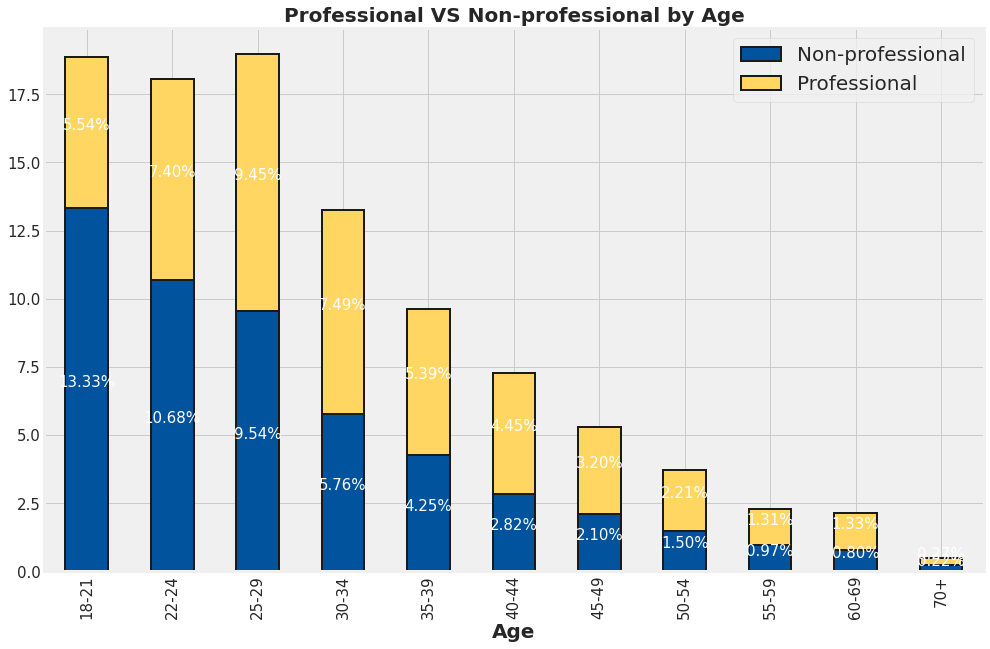

In [17]:
age = 100 * pd.crosstab(response['Age'], response['professional'])/len(response) # Convert count into percentage

# barplot
ax_1 = age.plot.bar(stacked = True, color = {'#FFD662', '#00539C'}, figsize = (15,10),
                   linewidth = 2, edgecolor = 'k')

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.2f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 15,
             color = 'w') 

        
plt.xlabel('Age', fontsize = 20, weight = 'bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Professional VS Non-professional by Age', fontsize =20, weight = 'bold')
plt.legend(fontsize = 20)
plt.show()

It is obvious that the most professional respondants are distributed in both 25-29 and 30-34 age group while non-professionals are much younger. 

Let's see how different ages would be distributed by sub-category. (DS,DA, DE, Other)

In [18]:
# Professional vs Non-professional 
cond_pro = (response['professional'] == 'Professional')
pro = response[cond_pro]
nonpro = response[-cond_pro]

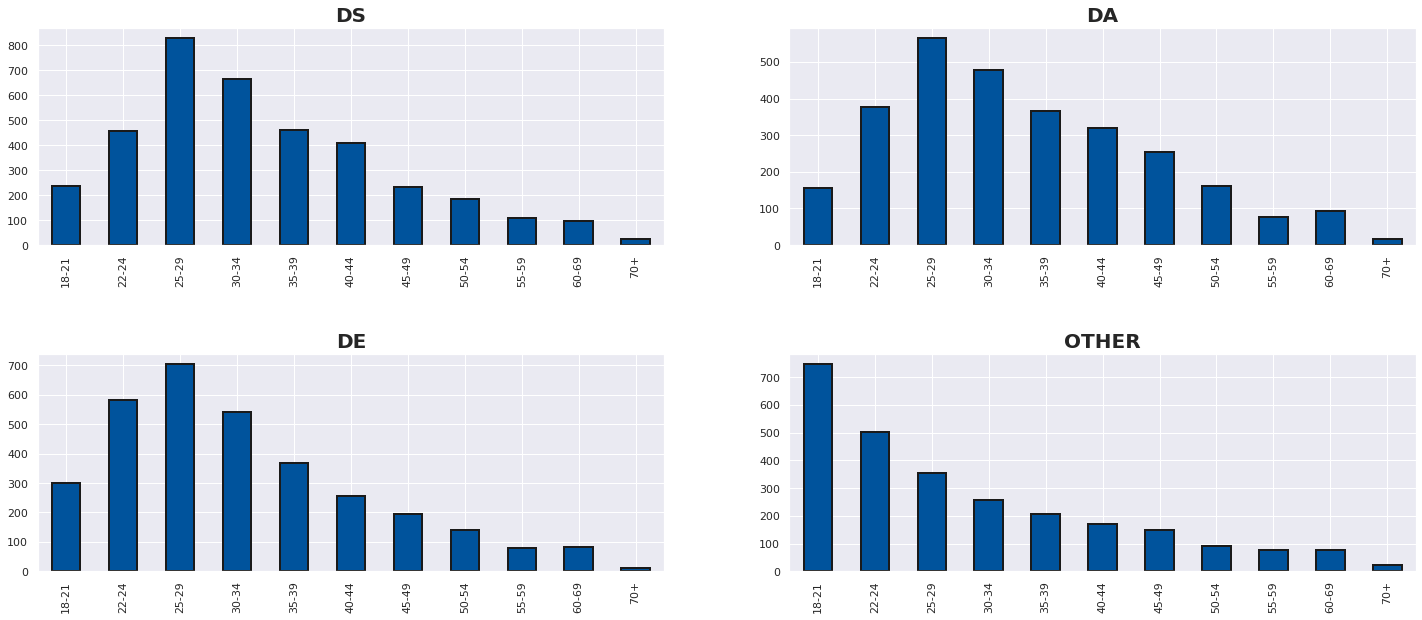

In [19]:
import itertools
plt.subplots(figsize = (22,10))
age_pro = pd.crosstab(pro['Age'], pro['RegroupJobTitle'])
# age_nonpro = pd.crosstab(nonpro['Age'], nonpro['RegroupJobTitle'])
category = ['DS','DA','DE','OTHER']
length = len(category)

sns.set_theme(style="darkgrid") # '#0A174E', '#F5D042'

for i, j in itertools.zip_longest(category, range(length)):
    plt.subplot( (length/2), 2, j+1) # nrows, ncols, index
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

    age_pro[i].plot.bar(color = '#00539C', linewidth = 2, edgecolor = 'k')
#     age_nonpro[i].plot.bar(color = '#D4C8BE')
    plt.title(i, size = 20, weight = 'bold')
    plt.xlabel('')
plt.show()

## 3.2 Gender

In [20]:
# Group other three gender types as 'others'
other_gender = ['Nonbinary', 'Prefer not to say', 'Prefer to self-describe']
response['Gender'] = response['Gender'].map(lambda x:'Others' if x in other_gender else x)
response['Gender'].value_counts()

# Professional vs Non-professional 
cond_pro = (response['professional'] == 'Professional')
pro = response[cond_pro]
nonpro = response[-cond_pro]

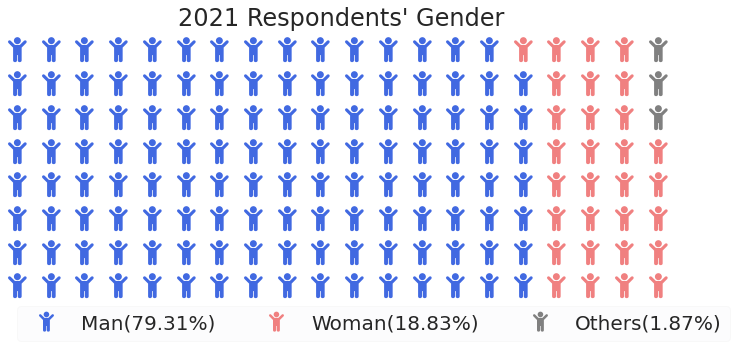

In [21]:
gender = response['Gender'].value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=8,
    columns=20,
    values=gender,
    colors=("royalblue", "lightcoral", 'gray'),
    title={'label': "2021 Respondents' Gender", 
           'loc': 'center',
          'fontdict': {
            'fontsize': 24
            }
          },
    legend={'labels': ["{}({:.2%})".format(a, b) for a, b in zip(gender.index, gender/len(response)) ],
            'loc': 'upper left',
            'bbox_to_anchor': (0, 0),
            'ncol': len(gender),
            'framealpha': 0.1,
            'fontsize': 20},

    font_size=25, 
    icons = 'child',
    icon_style = 'solid',
    figsize=(12, 5),  
    icon_legend=True
)

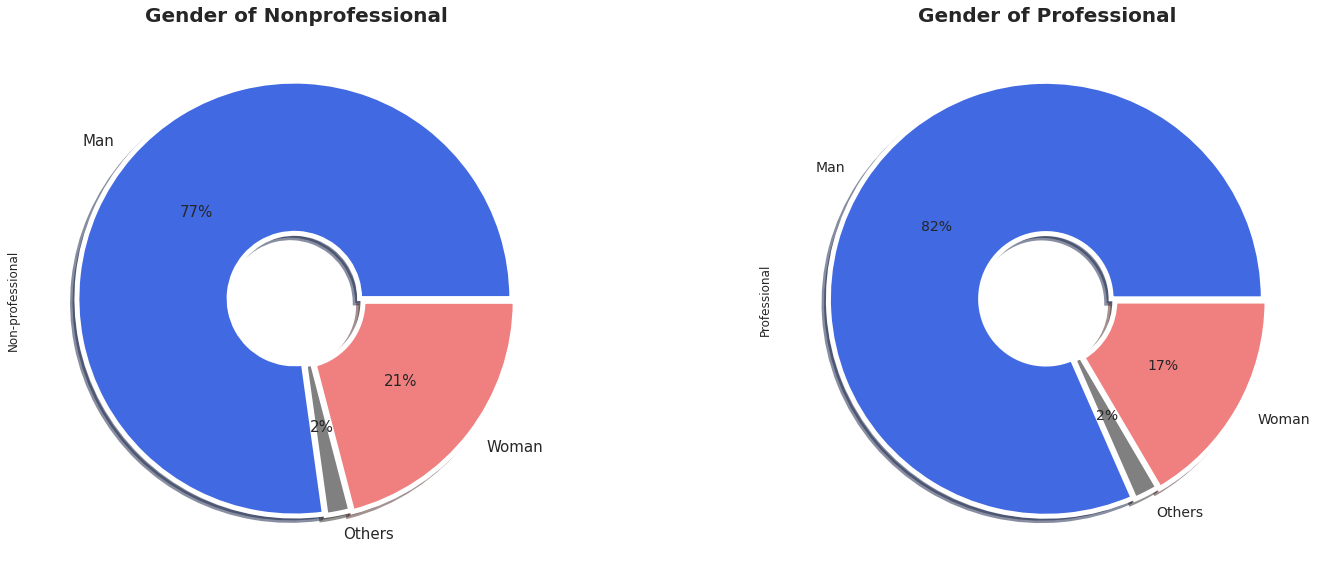

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
explode = [0.01, 0, 0.01]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# crosstab
gender = pd.crosstab(response['Gender'], response['professional'])

# Non-professional
gender['Non-professional'].plot.pie(autopct='%.0f%%', colors=["royalblue", 'gray',"lightcoral"], 
                                    explode=explode, wedgeprops=wedgeprops, 
                                    textprops={'fontsize': 15}, ax=ax[0], shadow = True)
# Professional
gender['Professional'].plot.pie(autopct='%.0f%%', colors=["royalblue", 'gray',"lightcoral"], 
                                explode=explode, wedgeprops=wedgeprops, 
                                textprops={'fontsize': 14}, ax=ax[1], shadow = True)
ax[0].set_title('Gender of Nonprofessional', size=20, weight = 'bold')
ax[1].set_title('Gender of Professional', size=20, weight = 'bold')
plt.show()

In general, **79.31% of respondants are men** while only **18.83% are women**. However, the proportion of women who has an interest in data-related job tends to get increased by 4% than the past.



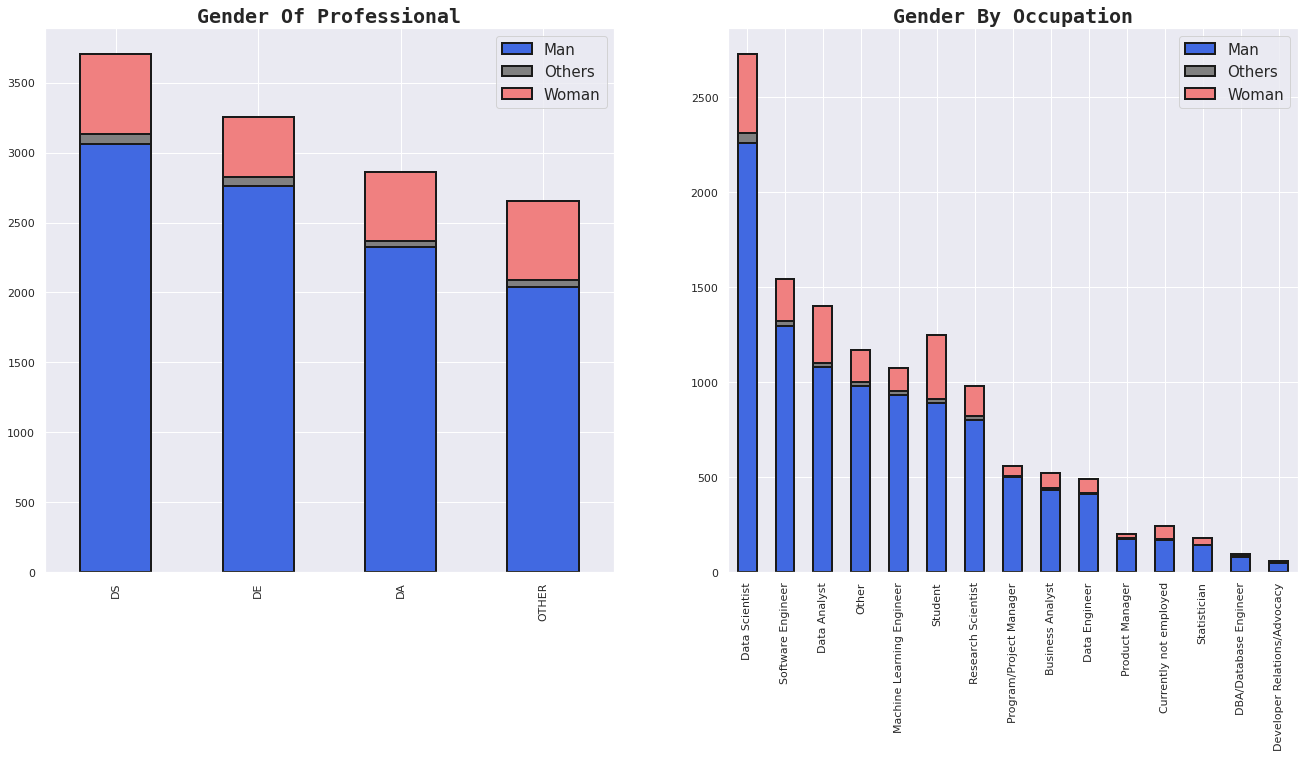

In [23]:
# Barplot
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
gender = pd.crosstab(pro['Gender'], pro['RegroupJobTitle']).T.sort_values(by='Man', ascending=False)
gender.plot.bar(stacked=True, color=["royalblue", 'gray',"lightcoral"], ax=ax[0], linewidth = 2, edgecolor = 'k')

gender_spe = pd.crosstab(pro['Gender'], pro['JobTitle']).T.sort_values(by='Man', ascending=False)
gender_spe.plot.bar(stacked=True, color=["royalblue", 'gray',"lightcoral"], ax=ax[1], linewidth = 2, edgecolor = 'k')

ax[0].set_title('Gender Of Professional', size=20, weight = 'bold', fontname = 'monospace')
ax[1].set_title('Gender By Occupation', size=20, weight = 'bold', fontname = 'monospace')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].legend(fontsize = 15)
ax[1].legend(fontsize = 15)

ax[0].tick_params(axis = 'both', which = 'major')
ax[1].tick_params(axis = 'both', which = 'major')

plt.show()

The above graph simply shows preferrable or popular jobs by each job title categories. 

It turns out that **data scientists** dominates over the others followed by both **software engineer and data analyst**. 


## 3.3 Country

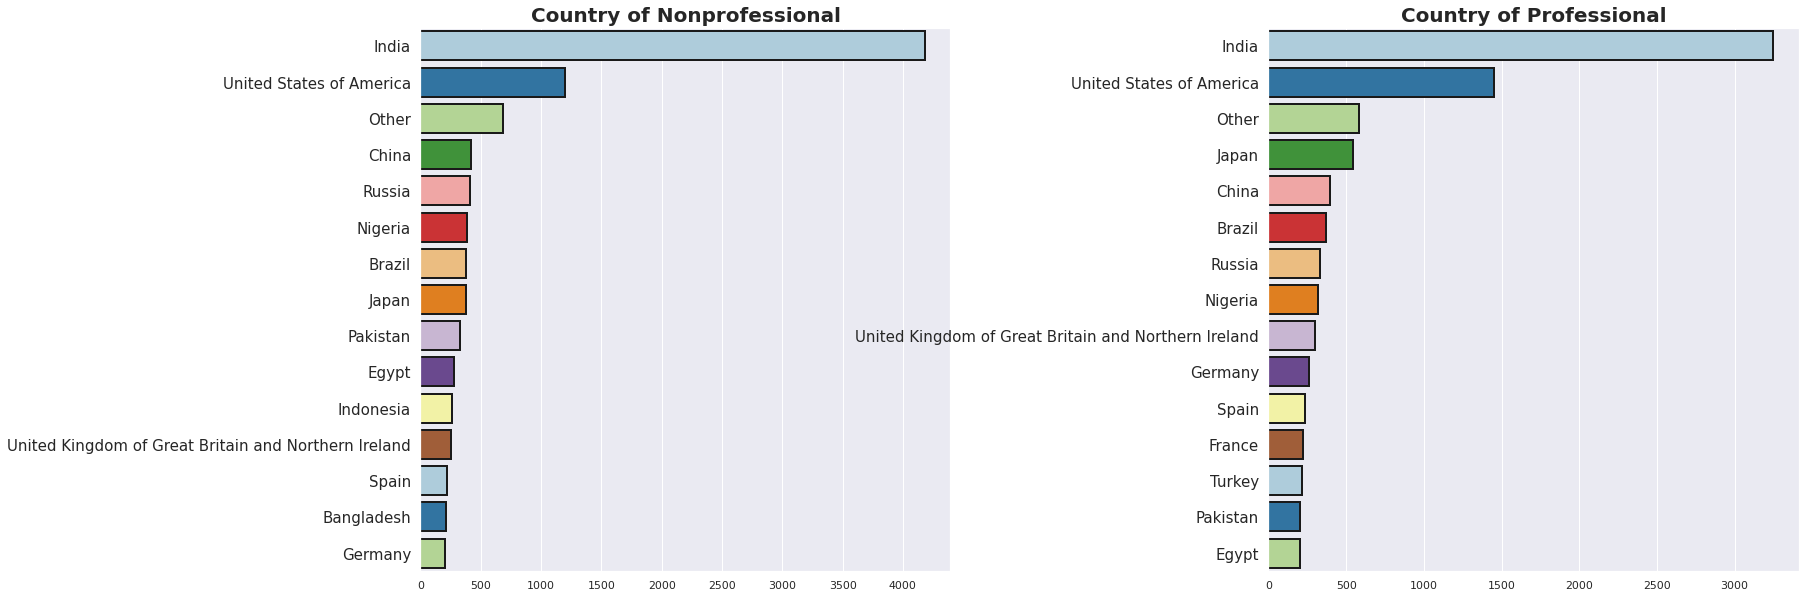

In [24]:
non_country = response[response['professional'] == 'Non-professional']['Country'].value_counts()[:15]
pro_country = response[response['professional'] == 'Professional']['Country'].value_counts()[:15]


fig, ax = plt.subplots(ncols=2, figsize=(22, 10))
sns.barplot(non_country, non_country.index, palette= 'Paired', ax=ax[0], linewidth = 2, edgecolor = 'k')
sns.barplot(pro_country, pro_country.index, palette='Paired', ax=ax[1], linewidth = 2, edgecolor = 'k')

plt.subplots_adjust(wspace=0.6, hspace=0.5)
ax[0].set_title('Country of Nonprofessional', size=20, weight = 'bold')
ax[1].set_title('Country of Professional', size=20, weight = 'bold')
ax[0].set_yticklabels(non_country.index, fontsize=15)
ax[1].set_yticklabels(pro_country.index, fontsize=15)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.show()

- Except for India and US, 

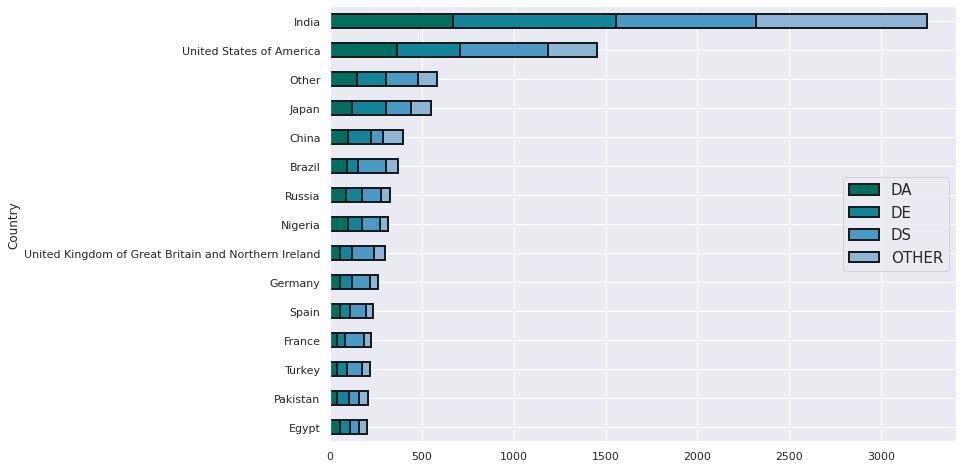

In [25]:
country_spe = pd.crosstab(pro['Country'], pro['RegroupJobTitle'])
country_spe['total'] = country_spe['DA'] + country_spe['DE'] + country_spe['DS'] + country_spe['OTHER']
country_spe = country_spe.sort_values('total', ascending=False)[:15].sort_values('total').drop('total', axis=1)

country_spe.plot.barh(stacked=True, color=sns.color_palette('PuBuGn_r'), figsize=(10, 8), linewidth = 2, edgecolor = 'k')
plt.legend(loc = 'center right', fontsize = 15)
plt.title('', fontsize = 30, fontname = 'monospace', weight = 'bold')
plt.show()

Obviously, most respondants are from either India or US. 

Indonesia and Bangladesh are listed in top 15 by Non-professional respondants where they are not listed in top 15 of professional respondants' country.

As the team members are all Korean, it is unfortunate not to see South Korea in top 15

## 3.4 Which Industry Across Job Title Would You Fit?

In [26]:
df = response.groupby(['RegroupJobTitle', 'JobIndustry'])['Age'].count().reset_index()
df = df[df['RegroupJobTitle'] != 'OTHER']
fig = px.treemap(df, path=[px.Constant("Job Title"), 'RegroupJobTitle', 'JobIndustry'], values='Age',
                  color='JobIndustry', title = 'Industry by Job Title'
                )
fig.update_traces(textinfo = 'label+percent parent')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

- The most actively popular industries across job titles are **Computers/Technoloy, Academics/Education and Accounting/Finance** 

- Unlike Data Analysis and Data Engineering, **Data Science** seems to focus more on **Academics/Education** than the others

- If you are interested in **Data Science** job, then it would require at least Master's degree since it has something to do with research. 

This will be covered later



## 3.5 Education

### 3.5.1 How Much Different Would Education Background Be Across  Professional Status?



In [27]:
response['FormalEducation'].value_counts()

Master                       10132
Bachelor                      9907
Doctoral degree or Higher     3155
Before Bachelor               2779
Name: FormalEducation, dtype: int64

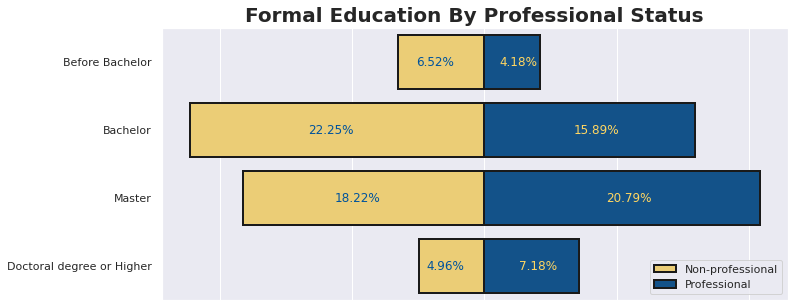

In [28]:
# Data Wrangling: Professional vs Non-professional by Education
total = response['FormalEducation'].value_counts().sum()

## Formal Education by professional as percentage over the entire respondants
### Non-professoinal
nonpro_edu = response[response['professional'] == 'Non-professional']['FormalEducation'].value_counts().to_frame()
nonpro_edu['FormalEducation'] = nonpro_edu['FormalEducation']*(-1) / total
### Professoinal
pro_edu =  response[response['professional'] == 'Professional']['FormalEducation'].value_counts() / total


# Plotting
order = np.array(['Before Bachelor', 'Bachelor', 'Master', 'Doctoral degree or Higher']).astype('object')
plt.figure(figsize=(10, 5))

## Non-professional
bar_plot = sns.barplot(y=nonpro_edu.index, x=nonpro_edu['FormalEducation'], order=order, color='#FFD662', 
                       label = 'Non-professional', linewidth = 2, edgecolor = 'k')
    
## Professional
bar_plot = sns.barplot(y=pro_edu.index, x=pro_edu.values, order=order, color='#00539C', 
                       label = 'Professional',linewidth = 2, edgecolor = 'k')

## Annotation
for rec in bar_plot.patches:
    height = rec.get_width()
    if height < 0:
        height_text = "{:.2%}".format( (-1) * height)
        x_loc = rec.get_x() - .005 + rec.get_width() / 2
        bar_plot.text(x_loc, 
              rec.get_y() + 0.5 + rec.get_x() / 2,
              height_text,
              ha='center', 
              va='bottom',
              color = '#00539C') 
    else:
        height_text = "{:.2%}".format(height)
        x_loc = rec.get_x() + .005 + rec.get_width() / 2
        bar_plot.text(x_loc, 
              rec.get_y() + 0.5 + rec.get_x() / 2,
              height_text,
              ha='center', 
              va='bottom',
              color = '#FFD662') 

## Remove x-axis label
plt.xlabel('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(loc = 'lower right')
plt.title('Formal Education By Professional Status', fontsize = 20, weight = 'bold')
plt.show()

- As **about 29% of respondants are Non-profession with either Bachelor's degree or before Bachelor's degree** followed by Master's degree, **majority of Non-professional respondants** tend to acquire at least Bachelor's degree. 

- Unlike Non-professional respondants, **about 28% of respondants are professionals with higher than bachelor's degree**.

### 3.5.2 Is Graduate Degree Needed To Get A Job?



In [29]:
# Data Wrangling
## Regroup Formal Education by 4 categorical standards: Before Bachelor vs Bachelor vs Master vs Doctoral or Higher
edu_level1 = response.groupby(['RegroupJobTitle','FormalEducation'])['Age'].count().reset_index().rename(columns = {'Age':'Count'})

## Regroup Formal Education by 2 categorical standards: Undergraduate or less vs Graduate
edu_level2 = response.groupby(['RegroupJobTitle','FormalEducation2'])['Age'].count().reset_index().rename(columns = {'Age':'Count'})


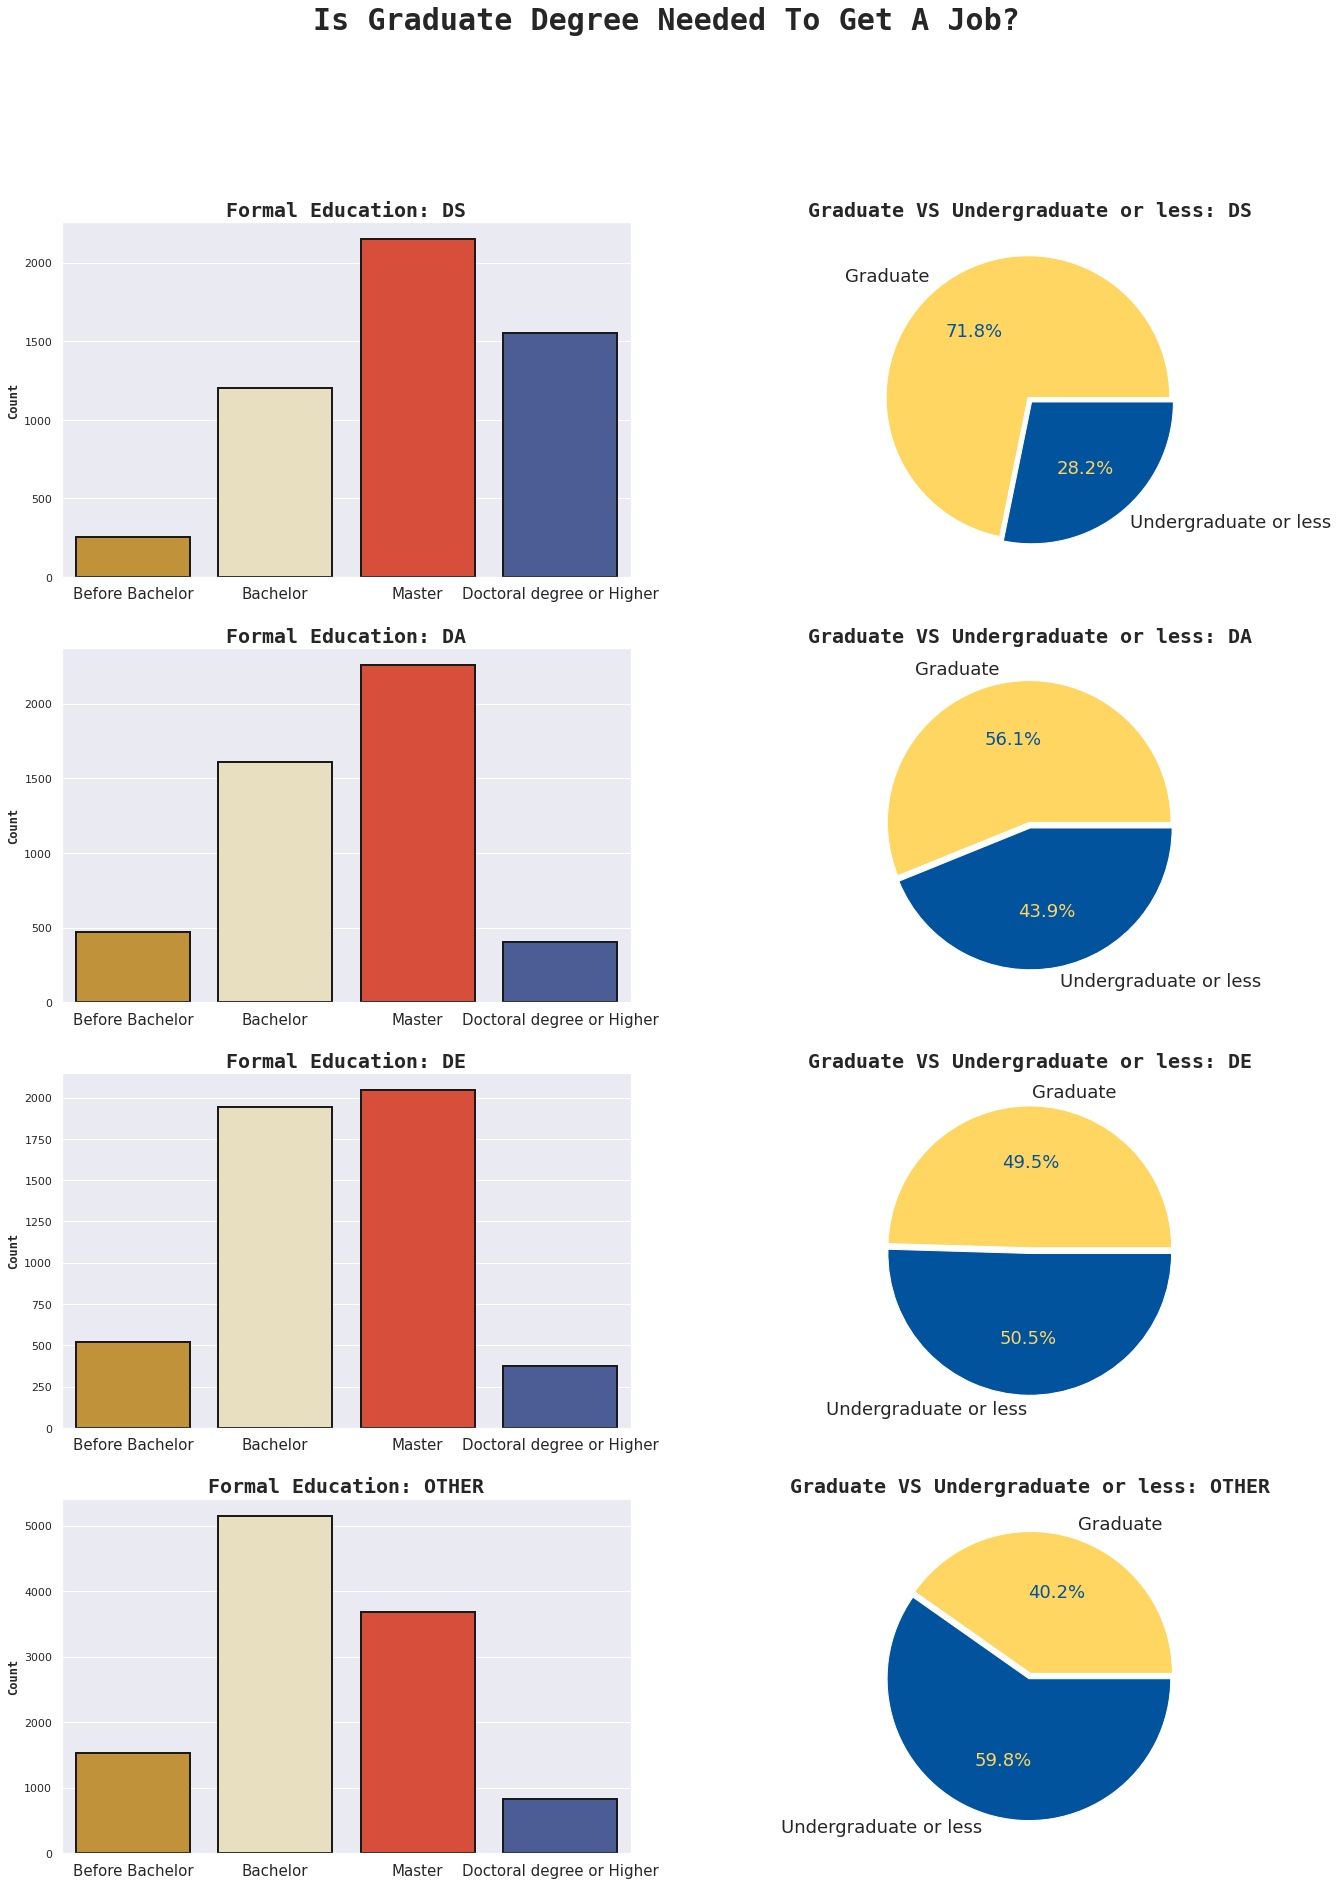

In [30]:
### Plotting
fig, ax = plt.subplots(4,2, figsize = (20,30))

# Orders
order=['DS', 'DA', 'DE', 'OTHER']
hue_order = ['Before Bachelor', 'Bachelor', 'Master', 'Doctoral degree or Higher']


i = 0 # Setting up the first axis
for job in order:   
    # 4 Education Levels
    ## Filter edu_level1 by RegroupJobTitle
    cond1 = (edu_level1['RegroupJobTitle'] == job)
    data1 = edu_level1[cond1]
        
    # Graduate vs Undergraduate
    ## Filter edu_level2 by RegroupJobTitle 
    cond2 = (edu_level2['RegroupJobTitle'] == job)
    data2 = edu_level2[cond2]
    
    # ------------ Bar Plot ------------- #
    ## Barplot
    sns.barplot(x = 'FormalEducation', y = 'Count', 
                data = data1,
                palette=['#D79922', '#EFE2BA', '#F13C20','#4056A1'], order = hue_order,
                linewidth = 2, edgecolor = 'k', ax = ax[i,0])
    
    ## Customize axis and labels
    ax[i,0].tick_params(axis='x', which='both', labelsize=15)
    ax[i,0].set_ylabel('Count', weight='semibold', fontname = 'monospace')
    ax[i,0].set_xlabel('')
    ax[i,0].set_title(f'Formal Education: {job}', 
                      fontsize = 20, weight = 'bold', 
                      fontname = 'monospace')

    # ------------ Pie Chart ------------- #
    ## Pie Chart: Graduate vs Undergraduate
    _, _, autotexts = ax[i,1].pie(data2.Count, labels = data2.FormalEducation2, 
                                    colors = np.array(['#FFD662', '#00539C']), 
                                    autopct='%1.1f%%',
                                    textprops={'fontsize': 18},
                                    explode = [0.02, 0.02])
    ## Customize Text Colors in Pie Chart
    text_colors = ['#00539C', '#FFD662']
    for text, color in zip(autotexts, text_colors):
        text.set_color(color)
    
    ## Pie Chart Title
    ax[i,1].set_title(f'Graduate VS Undergraduate or less: {job}', 
                      fontsize = 20, weight = 'bold', 
                      fontname = 'monospace')
    # Move to the next Job
    i += 1 
    
plt.suptitle('Is Graduate Degree Needed To Get A Job?', fontsize =30, weight = 'bold', fontname = 'monospace')

plt.show()


# Just in Case: 
# plt.get_cmap('flare_r')(np.linspace(0.2, 0.7, 4))

This information would give a helpful insight for those who consider to get a bigdata-related job but have no idea if graduate-level degree is needed. 

As the above represents, the answer for that question may vary by job title. 

- **Data Scientist (DS)**: The majority of respondants who work as DS has graudate-level degree
- **Data Analyst (DA)**: About 56.1% of respondants who work as DA has graudate-level degree, well-balanced
- **Data Engineer (DE)**: Degree does not matter for DE
- **Other** : The number of respondants with undergraduate-level is a bit higher than peaple with higher-level degree

To sum up, DS industry tends to require graduate-level degree while the others does not seem to care. Most of people would think that the higher formal education level is, the better in this industry. However, it does not necessary to spend tremendous amount of your resources to acquire higher-level degree depedning on what you are pursuing. **Thus, before making a decision whether to go to graudate school, please choose your path.**

## 3.6 Years to Code or Use Programming

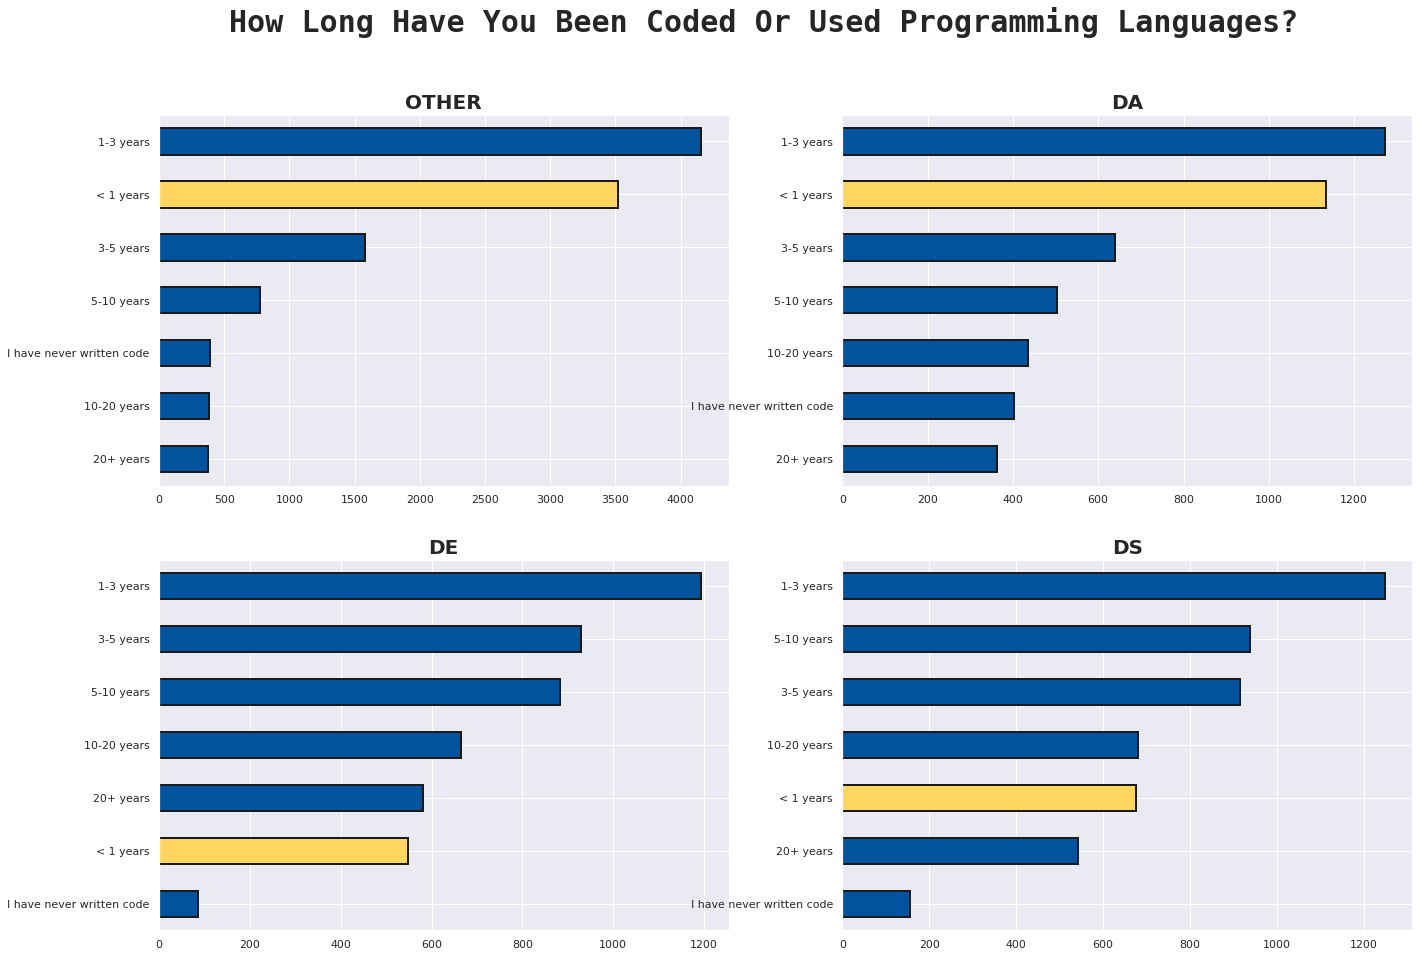

In [31]:
plt.subplots(figsize=(20,15))
job = response['RegroupJobTitle'].unique()
length = len(job)
col_color = {'< 1 years':'#FFD662',
             'I have never written code':'#00539C',
             '1-3 years':'#00539C',
             '3-5 years':'#00539C',
             '5-10 years':'#00539C',
             '10-20 years':'#00539C',
             '20+ years':'#00539C'}

for i, j in itertools.zip_longest(job, range(length)):
    plt.subplot((length/2), 2, j+1)
    data = response[response['RegroupJobTitle'] == i]['YearsToCode'].value_counts(ascending=True)
    data.plot(kind='barh', color=pd.DataFrame(data).reset_index()['index'].replace(col_color),
             linewidth = 2, edgecolor = 'k')
    plt.title(i, size=20, weight = 'bold')
plt.suptitle('How Long Have You Been Coded Or Used Programming Languages?', fontsize = 30, weight = 'bold', fontname = 'monospace')
plt.show()

- Excluding 'OTHER', **DA** does not heavily require a programming language comparing to others.

- If you are interested in either **DE** or **DS** job, they would like to expect you to be familiar with programming languages and tend to conduct coding test before job interview.

## 3.7 Which Tools Would The Experienced Suggest?

As we are all job seeker, the team also would like to know what tools need to be familiar to get a job. Let's see what the experienced would suggest.

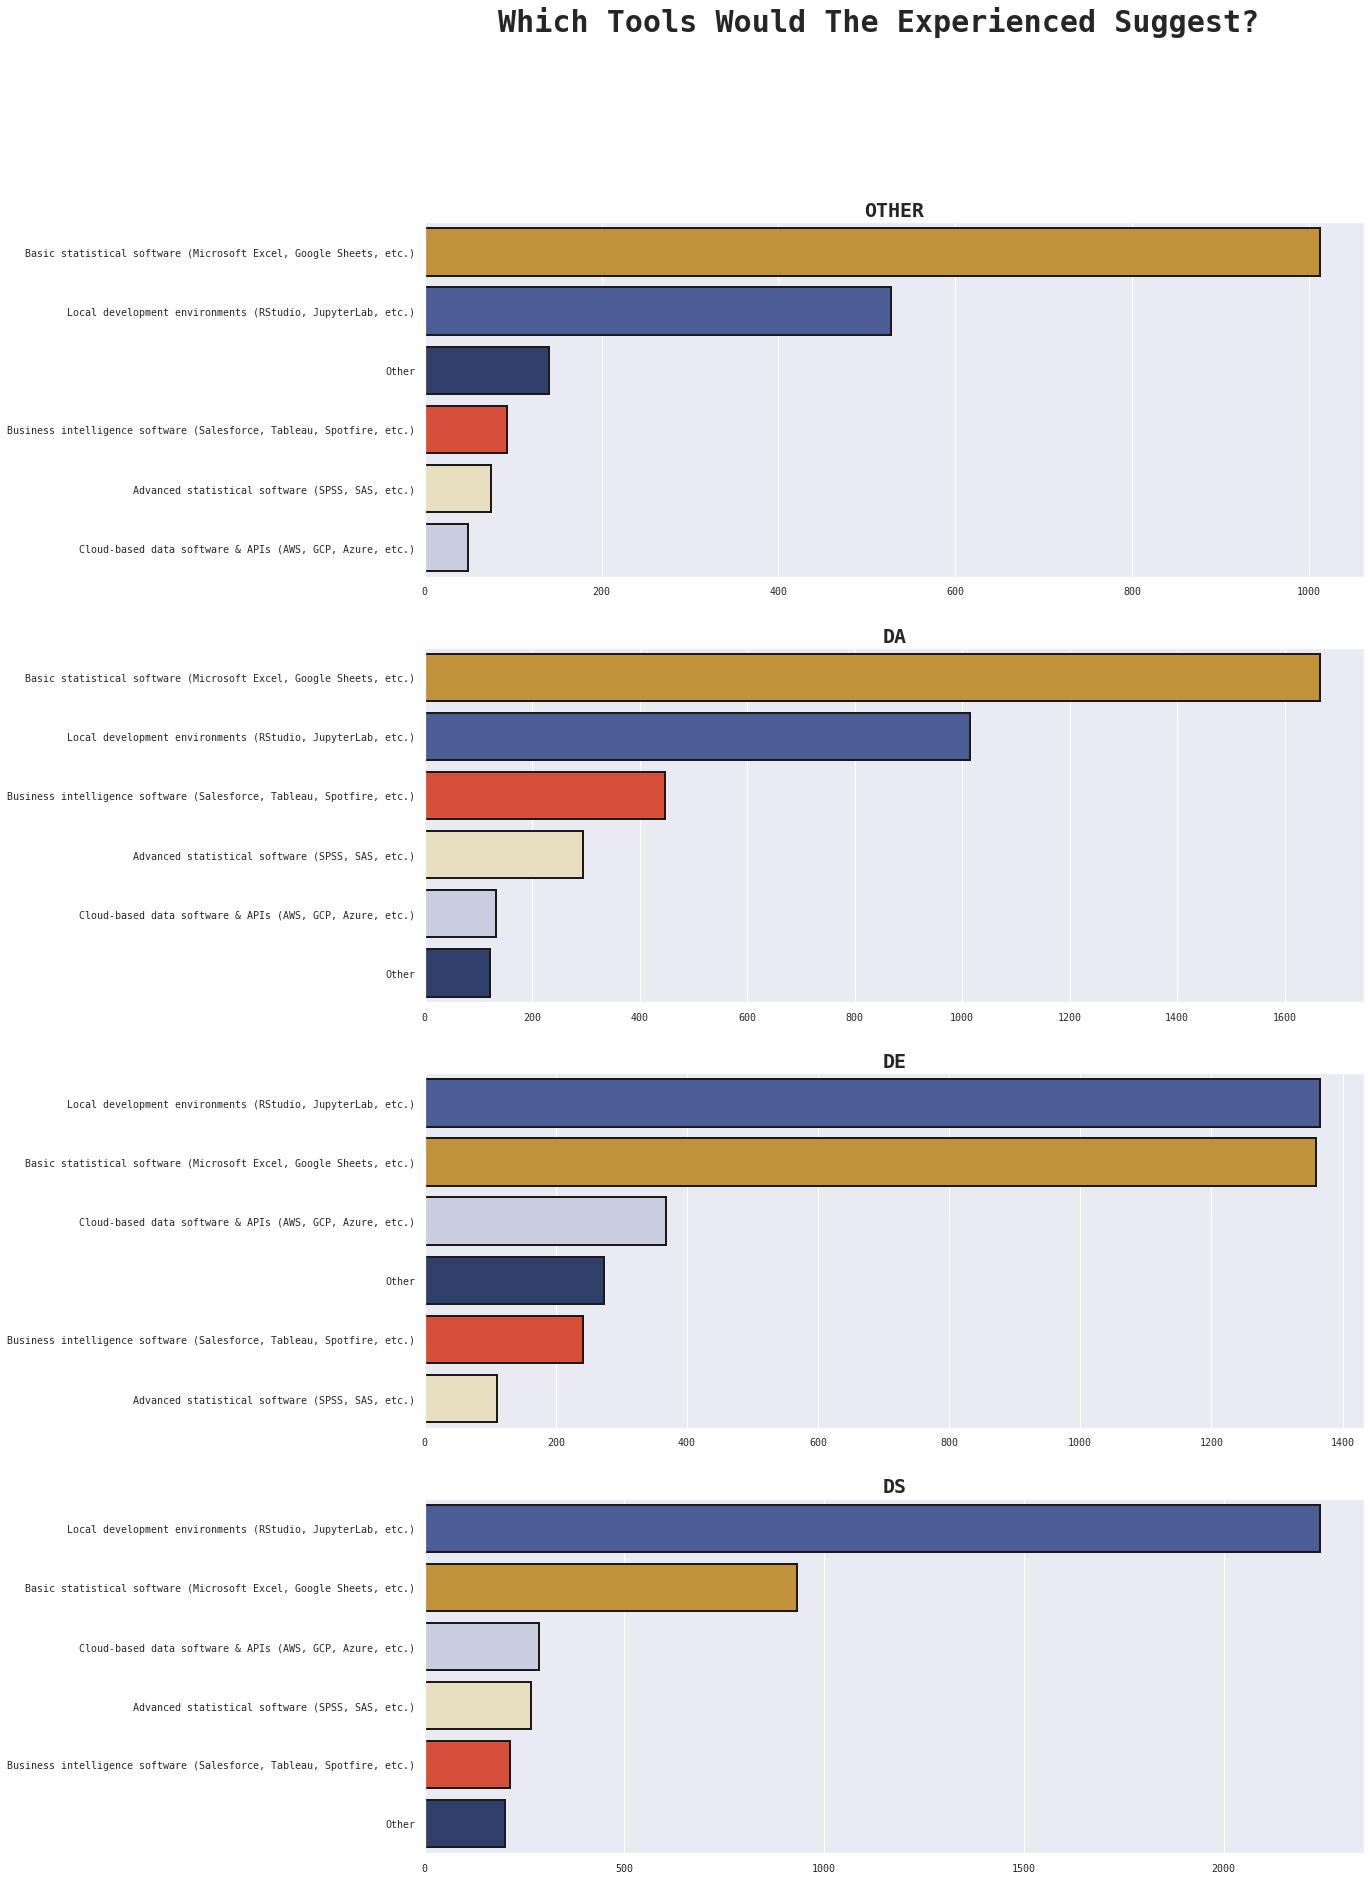

In [32]:
primary_tools = ['Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
        'Advanced statistical software (SPSS, SAS, etc.)',
        'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
        'Local development environments (RStudio, JupyterLab, etc.)',
        'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
        'Other']

# List of unique regrouped job titles
job = response['RegroupJobTitle'].unique()
length = len(job)

# Filter all the unexperienced respondants out from the data
cond_unexp = (response['JobTitle'] == 'Student') | (response['JobTitle'] == 'Currently not employed')
response_exp = response.copy()
response_exp = response_exp[-cond_unexp]

# Data Wrangling
exp_tool = response_exp.groupby(['RegroupJobTitle', 'PrimaryTool'])['Age'].count().reset_index().rename(columns = {'Age': 'Count'})

# Delete the empty from the data
exp_tool = exp_tool[exp_tool['PrimaryTool'] != '']


plt.subplots(figsize = (15,30))
# Plotting
for i, j in itertools.zip_longest(job, range(length)):
    plt.subplot(length,1, j+1)
    data = exp_tool[exp_tool['RegroupJobTitle'] == i].sort_values(by = ['Count'], ascending = False).reset_index(drop = True)  
    
    # Customize colors by index
    ## List colors where you want to allocate
    colors = ['#D79922', '#EFE2BA', '#F13C20','#4056A1','#C5CBE3','#273c75']
    
    ## Setting up colors by replacing index into allocated color
    col_color = {}
    for index, color in itertools.zip_longest(primary_tools, colors):    
        col_color = setting_colors(col_color, index, color)
    color = pd.DataFrame(data)['PrimaryTool'].replace(col_color)
    
    # barplot
    sns.barplot(y='PrimaryTool', x='Count',data = data, palette = color, linewidth = 2, edgecolor = 'k')
    plt.title(i, size=20, weight = 'bold', fontname = 'monospace')
    
    ## Setting up axis, labels, figure size
    plt.yticks(fontname = 'monospace', size = 10)
    plt.xticks(fontname = 'monospace', size = 10)
   
    plt.xlabel('')
    plt.ylabel('')
    
plt.subplots_adjust(wspace = 0.1, hspace =0.2)
plt.suptitle('Which Tools Would The Experienced Suggest?', fontsize = 30, weight = 'bold', fontname = 'monospace')
plt.show()

Unsurprisingly, **Data Engineer(DE)** are requiring **'Local Development Enviroments'** tool rather than 'Basic Statistical Software while **Data Analyst(DA) & Others** are exactly the opposite. The intersting part, though, is the fact that **those who want to be Data Scientist(DS) need to consider both 'Local Development Enviroments' and 'Basic Statistical Software'** having the same amount of responses.

In addition to the top two tools across job titles, **Data Analyst(DA)** needs to be familiar with **BI tools** as the third most requirements while **'Cloud-based data sofrware & APIs'** is followed for **Data Engineer (DE) & Data Scientist (DS)**.

Let's get into the following question: **which IDE and programming language would be required by job titles?** 

## 3.7.1 Programming Language To Use In Regular Basis

The team also explore how different languages to be prefered by job title. 

### List of Programming Language
- Python
- R
- SQL
- C
- C++
- Java
- Javascript
- Julia
- Swift
- Bash
- MATLAB
- None
- Other

In [33]:
# Customize colors by index
def setting_colors(col_color, index_name, color):
    '''
    col_color = dictionary that you want to update
    index_name = the index that you want to color (str)
    color = a color type (str)
    '''
    if len(col_color) == 0:
        col_color = {}
    else:
        col_color = col_color
    col_color.update({index_name: color})
    return col_color

In [34]:
response['Language_regular'] = response['Language_regular'].str.replace('C\++', '\++').str.replace('Javascript', 'JS')
lang = ['Python', 'R', 'SQL', 'C', '\++', 'Java', 'JS', 'Julia', 'Swift', 'Bash', 'MATLAB']

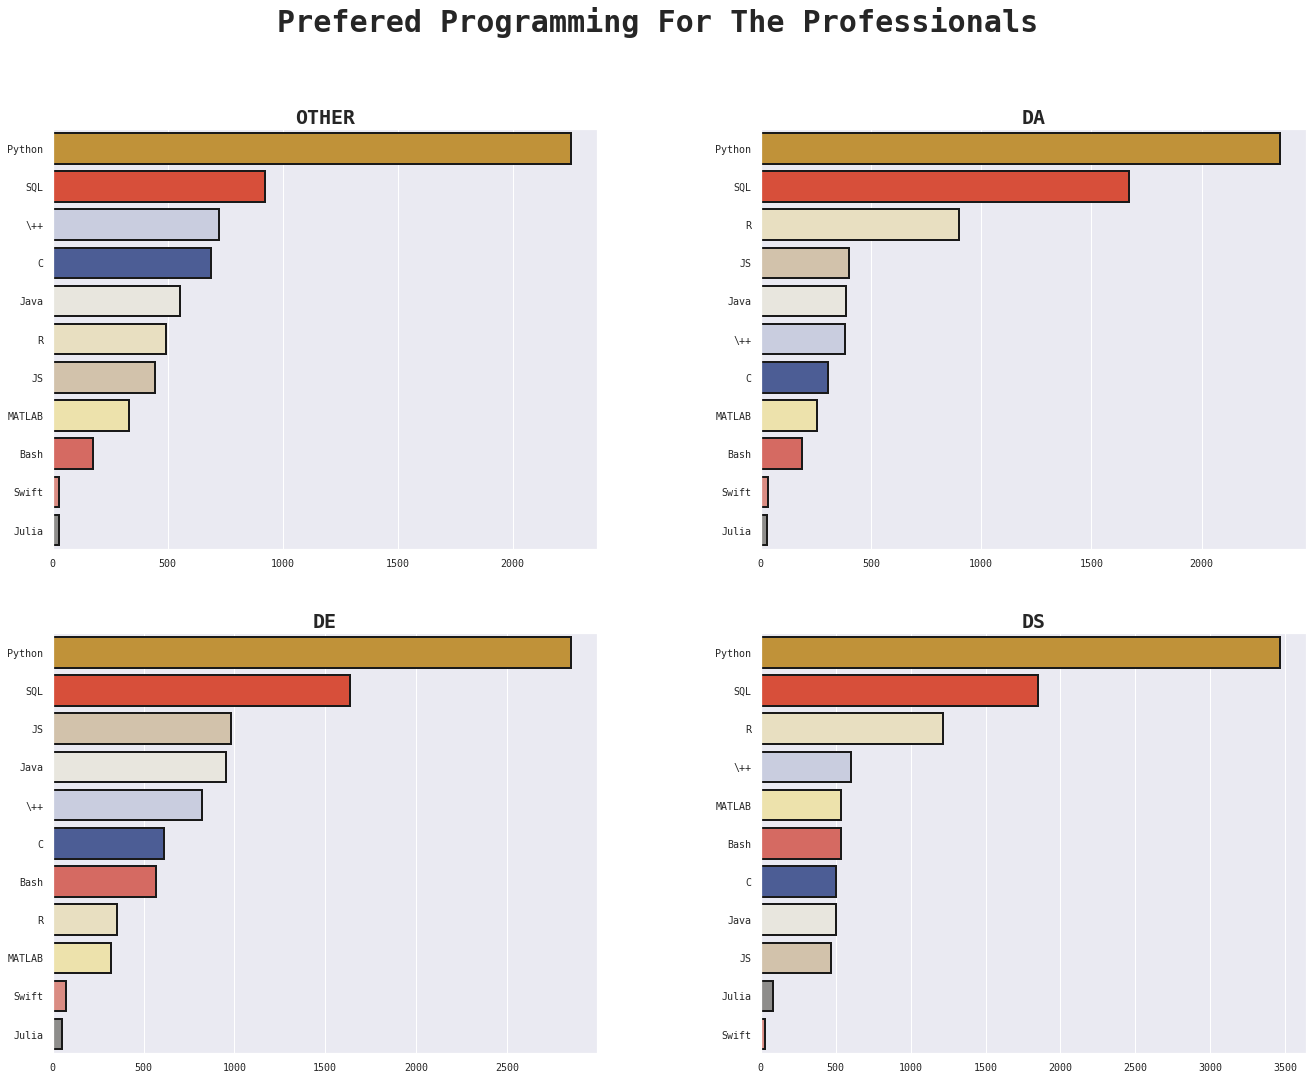

In [35]:
plt.subplots(figsize=(20,17))
job = response['RegroupJobTitle'].unique()
length = len(job)

for i, j in itertools.zip_longest(job, range(length)):
    plt.subplot((length/2), 2, j+1)
    data = response[(response['RegroupJobTitle'] == i) & (response['professional'] == 'Professional')]  

    lan = []
    cnt = []
    for k in lang:
        lan.append(k)
        cnt.append(len(data[data['Language_regular'].str.contains(k)]))

    df = pd.DataFrame(columns=["language", 'cnt'])
    df['language'] = lan
    df['cnt'] = cnt
    df = df.sort_values(by='cnt', ascending=False)
    # Customize colors by index
    ## List colors where you want to allocate
    colors = ['#D79922', '#EFE2BA', '#F13C20','#4056A1','#C5CBE3','#EAE7DC',
              '#D8C3A5','#8E8D8A','#E98074','#E85A4F','#F8E9A1']
    
    ## Setting up colors by replacing index into allocated color
    col_color = {}
    for index, color in itertools.zip_longest(lang, colors):    
        col_color = setting_colors(col_color, index, color)
    color = pd.DataFrame(df)['language'].replace(col_color)
    
    # barplot
    sns.barplot(y='language', x='cnt',data = df, palette = color, linewidth = 2, edgecolor = 'k')
    plt.title(i, size=20, weight = 'bold', fontname = 'monospace')
    
    ## Setting up axis, labels, figure size
    plt.yticks(fontname = 'monospace', size = 10)
    plt.xticks(fontname = 'monospace', size = 10)
    
    plt.xlabel('')
    plt.ylabel('')
    
plt.subplots_adjust(wspace = 0.3, hspace =0.2)
plt.suptitle('Prefered Programming For The Professionals', 
             fontsize = 30, weight = 'bold',fontname = 'monospace')
plt.show()    

- **Python and SQL** are the most popular programming language across all job title

- **R** is preferable to both **Data Science and Data Analysis** where statistics is one of necessary skills

- Those who want to be a **Data Engineer** should be familiar with **Java Script, Java and C based language**

## 3.7.1 Which IDE Would You Need By Job Title?

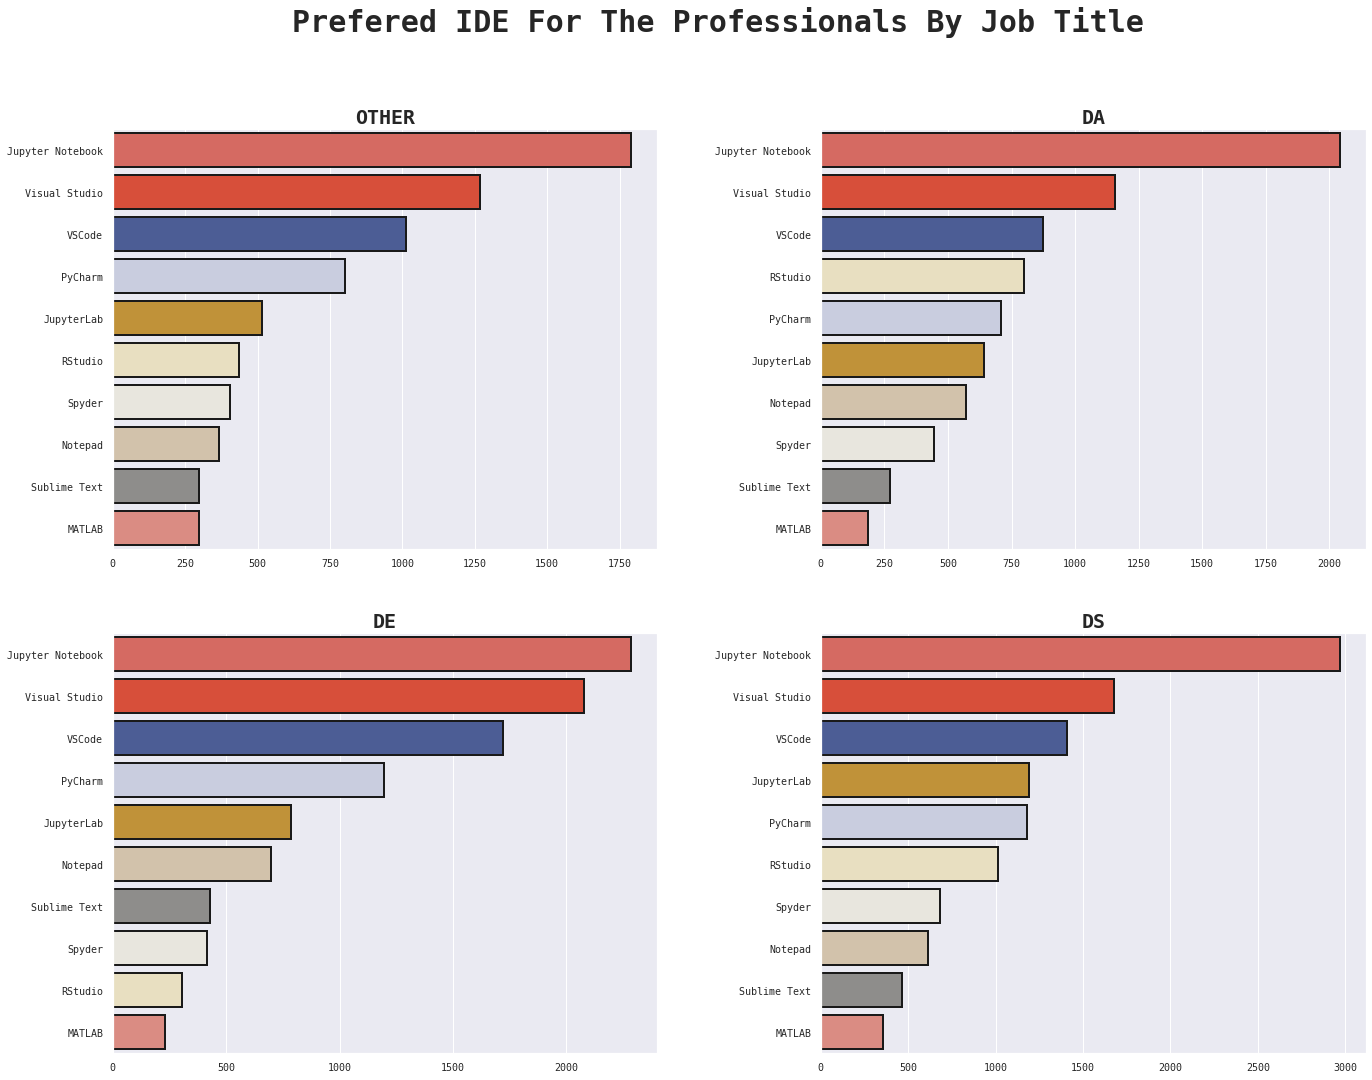

In [36]:
idle = ['JupyterLab', 'RStudio', 'Visual Studio', 'VSCode', 'PyCharm', 'Spyder', 'Notepad',
        'Sublime Text', 'MATLAB', 'Jupyter Notebook']

plt.subplots(figsize=(20,17))
job = response['RegroupJobTitle'].unique()
length = len(job)

for i, j in itertools.zip_longest(job, range(length)):
    plt.subplot((length/2), 2, j+1)
    data = response[(response['RegroupJobTitle'] == i) & (response['professional'] == 'Professional')]  

    ide = []
    cnt = []
    for k in idle:
        ide.append(k)
        cnt.append(len(data[data['IDE'].str.contains(k)]))

    df = pd.DataFrame(columns=["ide", 'cnt'])
    df['ide'] = ide
    df['cnt'] = cnt
    df = df.sort_values(by='cnt', ascending=False)
    # Customize colors by index
    ## List colors where you want to allocate
    colors = ['#D79922', '#EFE2BA', '#F13C20','#4056A1','#C5CBE3','#EAE7DC',
              '#D8C3A5','#8E8D8A','#E98074','#E85A4F','#F8E9A1']
    ## Setting up colors by replacing index into allocated color
    col_color = {}
    for index, color in itertools.zip_longest(idle, colors):    
        col_color = setting_colors(col_color, index, color)
    color = pd.DataFrame(df)['ide'].replace(col_color)
    
    # barplot
    sns.barplot(y='ide', x='cnt',data = df, palette = color, linewidth = 2, edgecolor = 'k')
    plt.title(i, size=20, weight = 'bold', fontname = 'monospace')
    
    ## Setting up axis, labels, figure size
    plt.yticks(fontname = 'monospace', size = 10)
    plt.xticks(fontname = 'monospace', size = 10)
    plt.xlabel('')
    plt.ylabel('')
  

plt.subplots_adjust(wspace = 0.3, hspace =0.2)  
plt.suptitle('Prefered IDE For The Professionals By Job Title', fontsize = 30, weight = 'bold',fontname = 'monospace')
plt.show()

In [37]:
response.PublicToDeploy

0                       GitHub , Kaggle 
1                                       
2        I do not share my work publicly
3                                       
4        I do not share my work publicly
                      ...               
25968                    GitHub , Colab 
25969                                   
25970                                   
25971                                   
25972                                   
Name: PublicToDeploy, Length: 25973, dtype: object

# <center> Work in progress! <br>

## <center> If you like our work or have any questions, <br><br> please leave a comment and give it a like 

## <center> Thanks for your attention

# 추가

## Compensation

In [38]:
# grouping
response.loc[response['Year_Compensation'] == '', 'compensation'] = '0'
response.loc[response['Year_Compensation'] == '$0-999', 'compensation'] = '0.1k'
response.loc[response['Year_Compensation'].isin(['1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499', '7,500-9,999']), 'compensation'] = '1k'
response.loc[response['Year_Compensation'].isin(['10,000-14,999', '15,000-19,999', '20,000-24,999', '25,000-29,999', '30,000-39,999',
                                                 '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999', '90,000-99,999']), 'compensation'] = '10k'
response.fillna('100k', inplace=True)

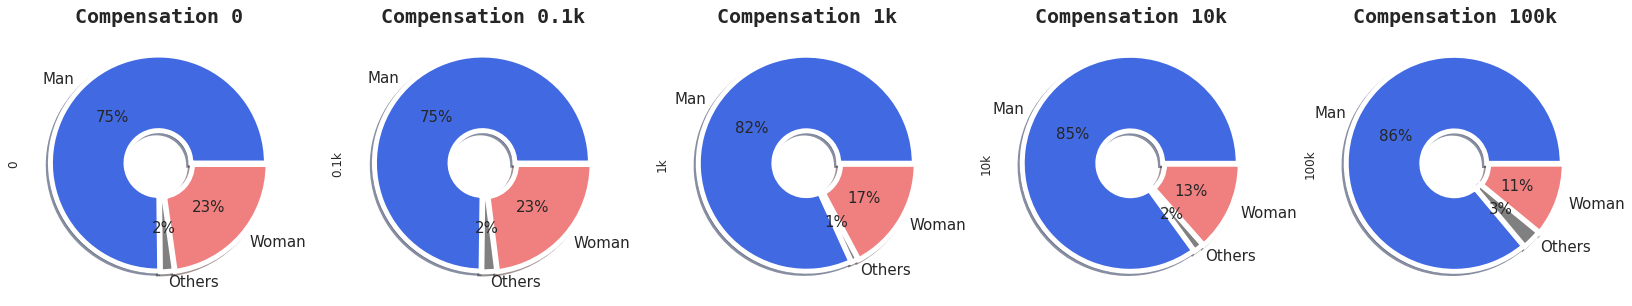

In [39]:
# Compensation by gender

fig, ax = plt.subplots(1, 5, figsize=(25, 15))
explode = [0.01, 0, 0.01]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
index = ['0', '0.1k', '1k', '10k', '100k']

compensation = pd.crosstab(response['Gender'], response['compensation'])
compensation = compensation[index] ## 순서 정렬

for i, j in enumerate(compensation.columns):
  compensation[j].plot.pie(autopct='%.0f%%', colors=["royalblue", 'gray',"lightcoral"], 
                                      explode=explode, wedgeprops=wedgeprops, 
                                      textprops={'fontsize': 15}, ax=ax[i], shadow = True)
  ax[i].set_title(f'Compensation {j}', size=20, weight = 'bold', fontname = 'monospace')
plt.show()

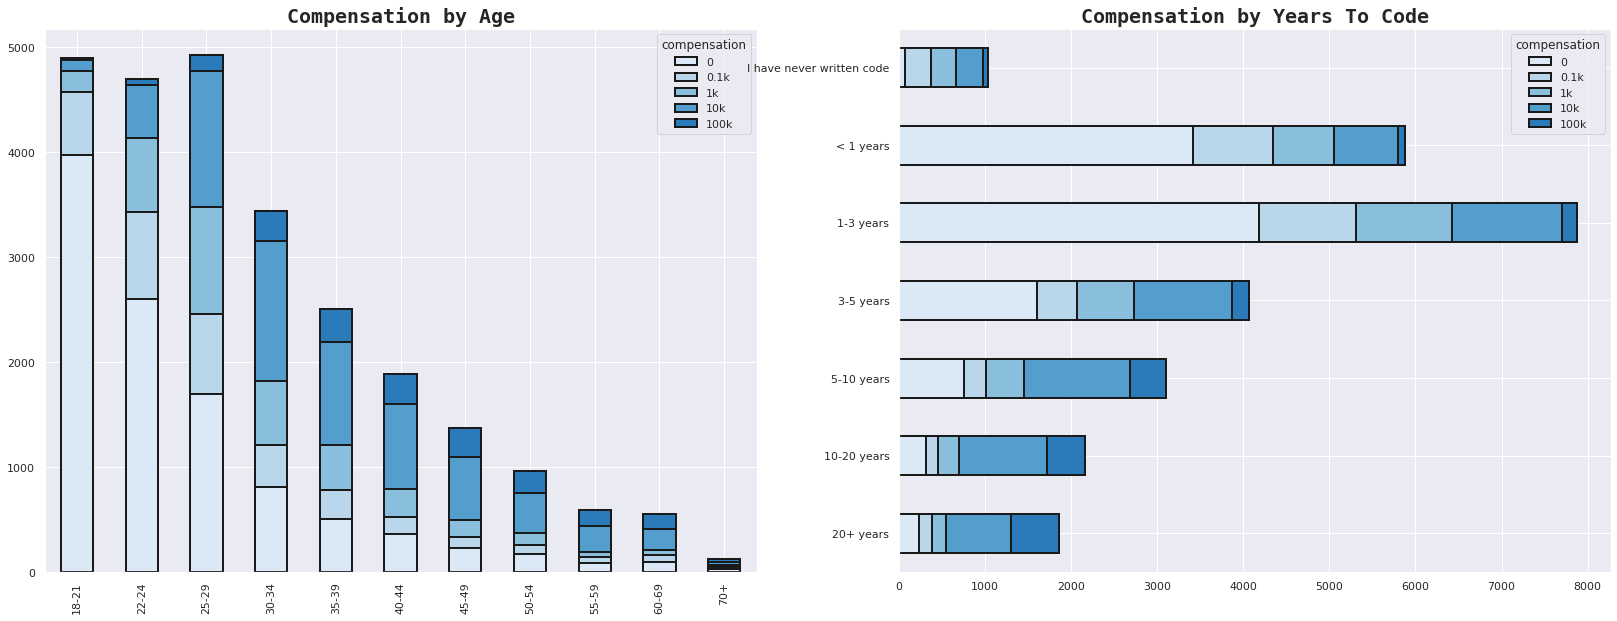

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Compensation by Age
compensation = pd.crosstab(response['Age'], response['compensation'])
compensation = compensation[index]
compensation.plot.bar(stacked=True, figsize=(25,10), color=sns.color_palette('Blues'), linewidth = 2, edgecolor = 'k', ax=ax[0])
ax[0].set_title('Compensation by Age', size=20, weight = 'bold', fontname = 'monospace')
ax[0].set_xlabel('')

# Copmensation by Years To Code
compensation = pd.crosstab(response['YearsToCode'], response['compensation'])
compensation = compensation.T[['20+ years', '10-20 years', '5-10 years', '3-5 years', '1-3 years', '< 1 years', 'I have never written code']].T
compensation = compensation[index]
compensation.plot.barh(stacked=True, figsize=(25,10), color=sns.color_palette('Blues'), linewidth = 2, edgecolor = 'k', ax=ax[1])
ax[1].set_title('Compensation by Years To Code', size=20, weight = 'bold', fontname = 'monospace')
ax[1].set_ylabel('')

plt.show()

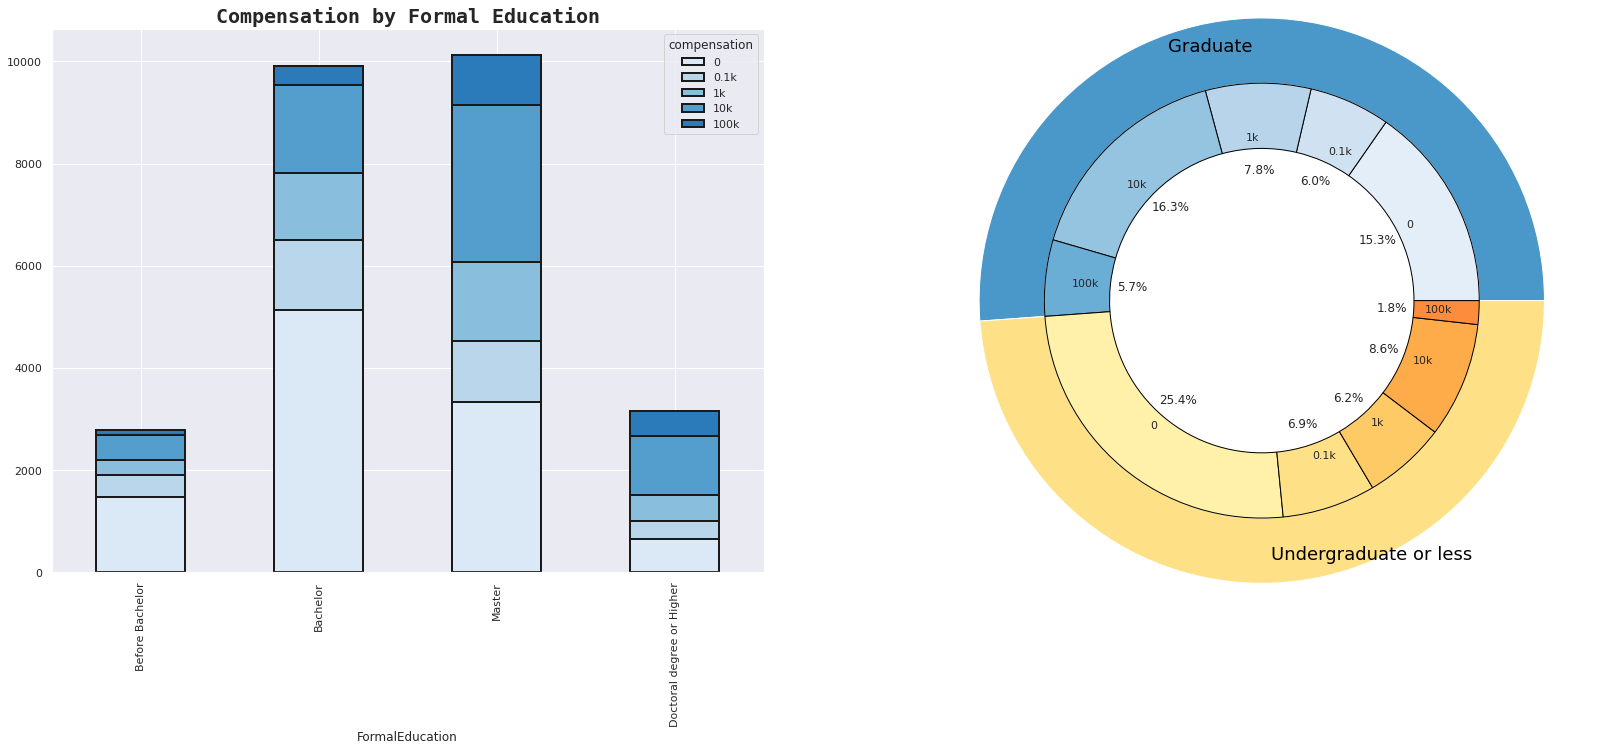

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Compensation by FormalEducation
compensation = pd.crosstab(response['FormalEducation'], response['compensation'])
compensation = compensation.T[['Before Bachelor', 'Bachelor', 'Master', 'Doctoral degree or Higher']].T
compensation = compensation[index]
compensation.plot.bar(stacked=True, figsize=(25,10), color=sns.color_palette('Blues'), linewidth = 2, edgecolor = 'k', ax=ax[0])
ax[0].set_title('Compensation by Formal Education', size=20, weight = 'bold', fontname = 'monospace')

# Compensation by Graduate Degree
compensation = pd.crosstab(response['compensation'], response['FormalEducation2'])
compensation = compensation.T[index].T
group_sizes = [sum(compensation['Graduate']), sum(compensation['Undergraduate or less'])]
group_names = compensation.columns
a, b= [plt.cm.Blues, plt.cm.YlOrRd]
subgroup_names = ['0', '0.1k', '1k', '10k', '100k', '0', '0.1k', '1k', '10k', '100k']
subgroup_sizes = list(compensation['Graduate'].values)+list(compensation['Undergraduate or less'].values)

# Compensation by FormalEducation
## Outside Ring
ax[1].axis('equal')
pie_outside, _ = ax[1].pie(group_sizes, 
                        radius=1.3,  textprops={'fontsize': 18, 'color':'black'},
                        labels=group_names, 
                        labeldistance=0.9,
                        colors=[a(0.6), b(0.2)])
plt.setp(pie_outside, width=0.3, edgecolor='white')
## Inside Ring
pie_inside, plt_labels, junk =  ax[1].pie(subgroup_sizes, radius=(1.3 - 0.3),  labels=subgroup_names,
                                       labeldistance=0.75, autopct='%1.1f%%', colors=[a(0.1), a(0.2), a(0.3), a(0.4), a(0.5),
                                                                                      b(0.1), b(0.2), b(0.3), b(0.4), b(0.5)])
plt.setp(pie_inside, width=0.3, edgecolor='black')
plt.show()

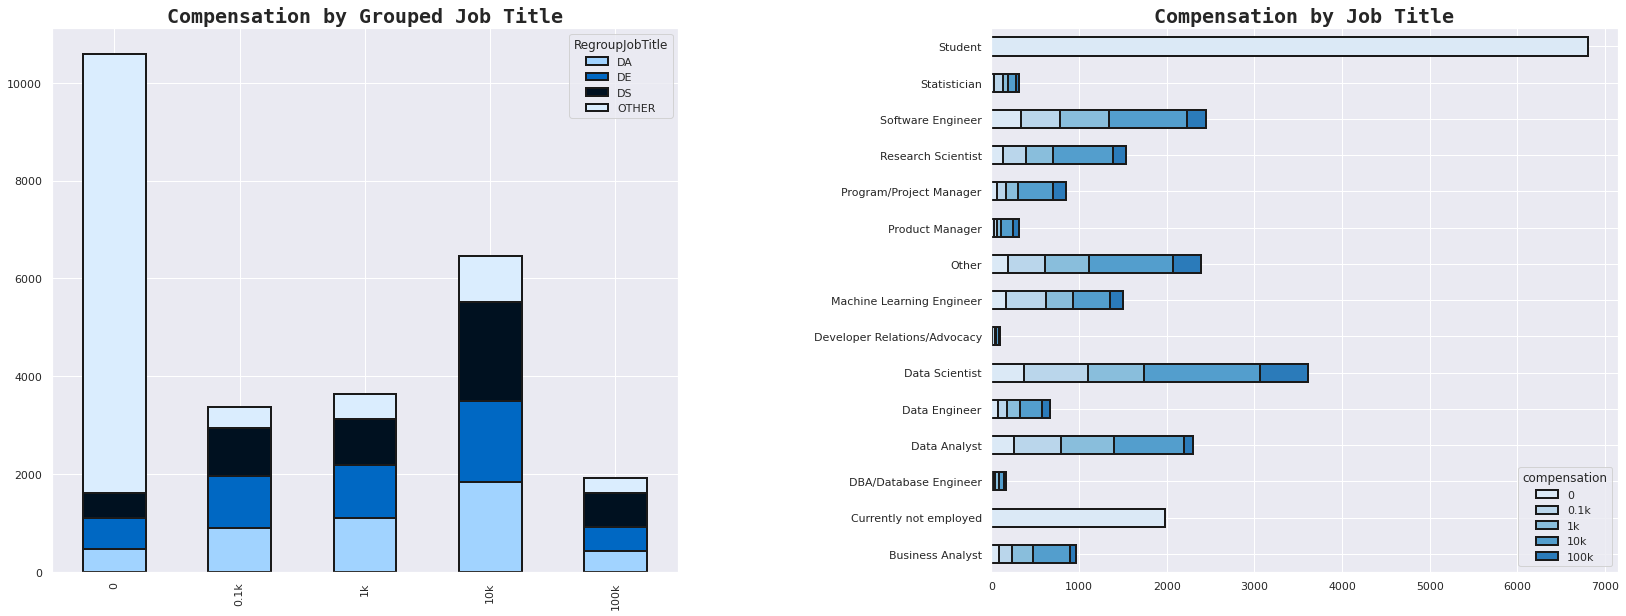

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

# Compensation by DA/DS/DE
color = {'DA':'#a1d3ff', 'DE':'#0068c3', 'DS':'#001120', 'OTHER':'#daedfe'}

compensation = pd.crosstab(response['compensation'], response['RegroupJobTitle'])
compensation = compensation.T[index].T ## 순서 정렬
compensation.plot.bar(stacked=True, figsize=(25,10), color=color, linewidth = 2, edgecolor = 'k', ax=ax[0])
ax[0].set_title('Compensation by Grouped Job Title', size=20, weight = 'bold', fontname = 'monospace')
ax[0].set_xlabel('')

# Compensation by JobTitle
compensation = pd.crosstab(response['JobTitle'], response['compensation'])
compensation = compensation[index]
compensation.plot.barh(stacked=True, figsize=(25,10), color=sns.color_palette('Blues'), linewidth = 2, edgecolor = 'k', ax=ax[1])
ax[1].set_title('Compensation by Job Title', size=20, weight = 'bold', fontname = 'monospace')

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.ylabel('')
plt.show()

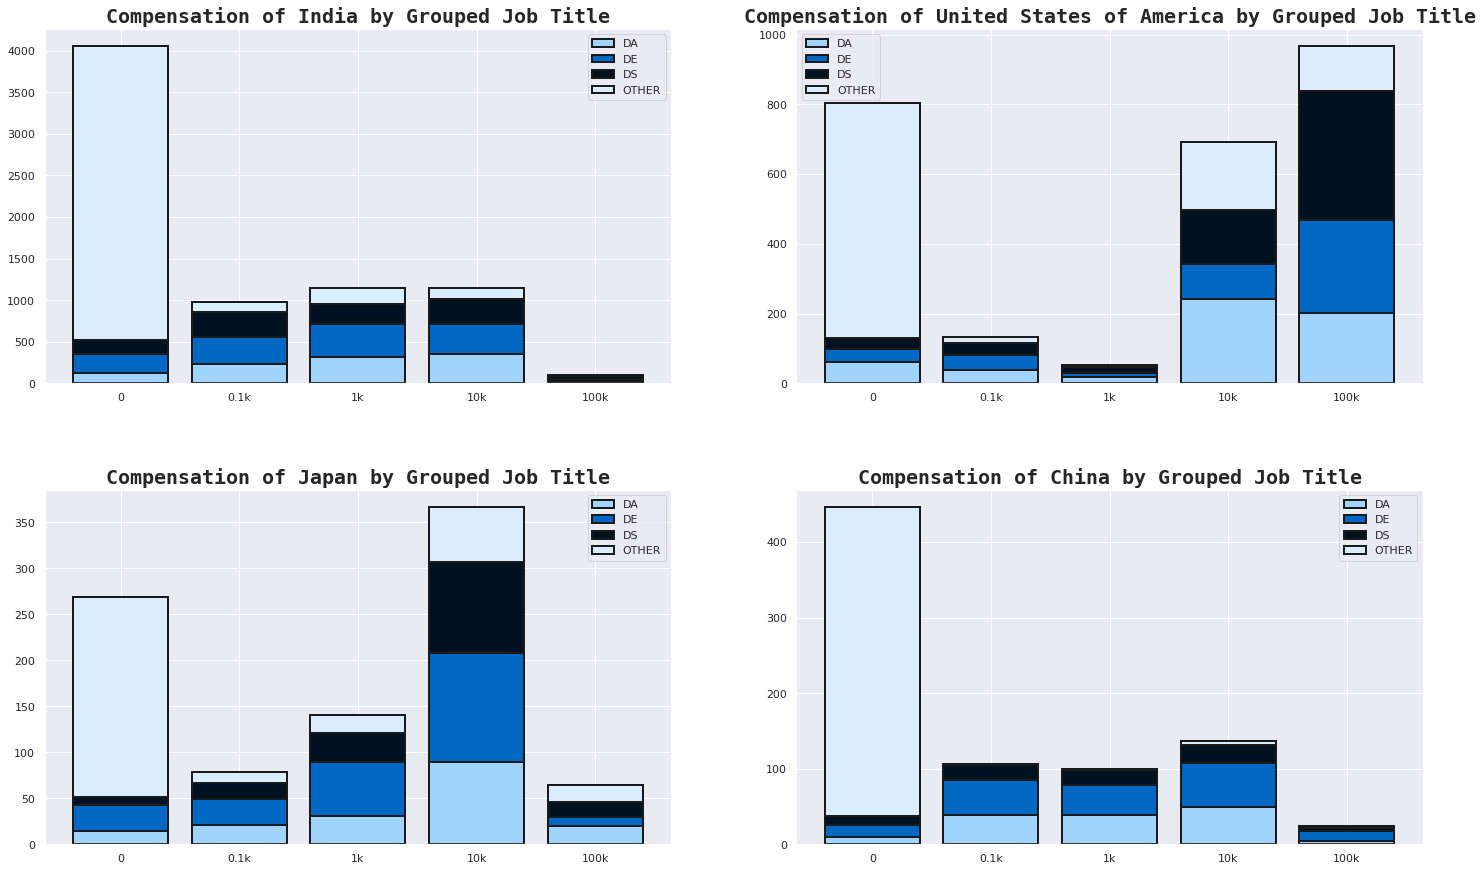

In [46]:
fig, ax = plt.subplots(figsize=(22, 15))

# compensation with respondents Top 4 country

for i, j in enumerate(['India','United States of America', 'Japan', 'China']):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.3)

    compensation = pd.crosstab(response['compensation'], response[response['Country'] == j]['RegroupJobTitle'])
    compensation = compensation.T[index].T
    
    ## stack
    a_bottom = np.add(compensation['DA'], compensation['DE'])
    b_bottom = np.add(a_bottom, compensation['DS'])

    p1 = plt.bar(compensation.index, compensation['DA'], color = '#a1d3ff', linewidth = 2, edgecolor = 'k' )
    p2 = plt.bar(compensation.index, compensation['DE'], bottom=compensation['DA'], color = '#0068c3', linewidth = 2, edgecolor = 'k') 
    p3 = plt.bar(compensation.index, compensation['DS'], bottom=a_bottom, color = '#001120', linewidth = 2, edgecolor = 'k')
    p4 = plt.bar(compensation.index, compensation['OTHER'], bottom=b_bottom, color = '#daedfe', linewidth = 2, edgecolor = 'k')
    plt.legend((p1[0], p2[0], p3[0], p4[0]), ('DA','DE','DS','OTHER'))
    plt.title(f'Compensation of {j} by Grouped Job Title', size=20, weight = 'bold', fontname = 'monospace')
plt.show()

# Media

In [49]:
def make_dataframe(job, column, n=None):
  """ 직군별, 특정 컬럼에 대한 상위 n개 카운팅 데이터를 리턴하는 함수입니다."""
  
  df = response[(response['RegroupJobTitle']==job) & (response['professional']=='Professional')]

  ls = []
  for i in df[column].value_counts().index:
    if i != '' and i != 'None': ## Null 값 제거
      import re
      text = re.sub(r'\([^)]*\)', '', i) ## 괄호 속 문자 제거
      text = text.split(',')
      if text not in ls:
        ls = list(set(ls + text))

  lss = [i.strip() for i in ls] ## 공백 제거

  data = response[response['RegroupJobTitle'] == job] 

  cnt = []
  for k in lss:
      cnt.append(len(data[data[column].str.contains(k)]))

  df1 = pd.DataFrame(columns=[column, 'cnt'])
  df1[column] = lss
  df1['cnt'] = cnt

  if n==None:
    df1 = df1.sort_values('cnt', ascending=False)
  else:
    df1 = df1.sort_values('cnt', ascending=False)[:n]
  
  return df1

In [53]:
column = ['PublicToDeploy', 'PlatformToLear_DS', 'MediaSourceToLearn' ]
length = len(column)
colors = {'DA':'#a1d3ff', 'DE':'#0068c3', 'DS':'#001120', 'OTHER':'#daedfe'}

for i, j in itertools.zip_longest(column, range(length)) :

  # 각 직군별 카운팅 후 머지
  df1 = make_dataframe('DA', i)
  df2 = make_dataframe('DE', i)
  df3 = make_dataframe('DS', i)
  df1.columns = [i, 'DA']
  df2.columns = [i, 'DE']
  df3.columns = [i, 'DS']

  df = df1.merge(df2, on=i)
  df = df.merge(df3, on=i)
  df['Total'] = df['DA'] + df['DE'] + df['DS']
  df = df.sort_values('Total')
  df.drop('Total', axis=1, inplace=True)
  df.set_index(i, inplace=True)

  fig = go.Figure(data=[
      go.Bar(name='DA', x=df.index, y=df['DA'], marker_color=colors['DA']),
      go.Bar(name='DE', x=df.index, y=df['DE'], marker_color=colors['DE']),
      go.Bar(name='DS', x=df.index, y=df['DS'], marker_color=colors['DS'])
  ])

  # Change the bar mode
  fig.update_layout(title_text=f"{i} of the professional", title_x=0.5, barmode='group', xaxis_tickangle=-45, title_font_family='monospace' )

  fig.update_traces(marker_line_color='rgb(8,48,107)',
                    marker_line_width=1.5, opacity=0.6)
  #fig.show(renderer="colab")
  fig.show()
